In [1]:
!git clone https://github.com/camillasancricca/DATADIQ.git

Cloning into 'DATADIQ'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 235 (delta 43), reused 1 (delta 1), pack-reused 139 (from 1)
Receiving objects: 100% (235/235), 11.34 MiB | 3.45 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [2]:
!pip install ydata-profiling jaro-winkler recordlinkage

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.9/926.9 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.4 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=7703f01ad015981eac66126ab86acf2c4f59053a14010a8e17d53fce2b0d34ee
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3

In [3]:
#various imports
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import jaro
import matplotlib.pyplot as plt
from sklearn import ensemble
from DATADIQ import scripts_for_E5 as s
from sklearn.neighbors import NearestNeighbors
import recordlinkage

In [4]:
#function used to calculate the Z-Score during outlier detection phase
def ZS(data, threshold):
    mean = np.mean(data)
    sd = np.std(data) # calculate standard deviation
    outliers = [] # create empty list to store outliers
    for i in data: # detect outliers
        z = (i - mean) / sd  # calculate z-score
        if abs(z) > threshold:  # identify outliers
            outliers.append(i)  # add to the empty list

    # print outliers
    print("The detected outliers are: ", str(outliers))

In [5]:
#functions used to evaluate typos in 'Insegna' values with Jaro Winkler metric (during data wrangling phase)
def jaro_winkler_similarity(insegna, others, threshold):
    results = []
    for elem in others:
        similarity = jaro.jaro_winkler_metric(insegna, elem)
        if similarity >= threshold and similarity<1:
            results.append((elem, similarity))
    return results

def detect_typos(column, threshold):
    insegne_attivita = column.drop_duplicates()
    insegne_attivita = insegne_attivita.tolist()
    print(len(insegne_attivita))

    typo_results = []

    for elem in insegne_attivita:
        matches = jaro_winkler_similarity(elem, insegne_attivita, threshold=threshold)
        if len(matches) >= 1:
          typo_results.append((elem, matches))

    return typo_results

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import sys
sys.path.append('/content/drive/MyDrive/DIQProject')

1.DATA EXPLORATION AND PROFILING

In [8]:
DATA= pd.read_csv('/content/drive/MyDrive/DIQProject/Comune-di-Milano-Attivita-commerciali-di-media-e-grande-distribuzione.csv',sep=';',encoding='utf-16')
DATA

Settore Merceologico              Insegna  \
0                                          NaN                  NaN   
1                                          NaN                  NaN   
2                                          NaN                  NaN   
3                                          NaN                  NaN   
4                                          NaN                  NaN   
..                                         ...                  ...   
906  non alimentare;tabella speciale monopolio                  NaN   
907                tabella speciale carburanti                  NaN   
908                  tabella speciale farmacie             farmacia   
909                  tabella speciale farmacie  farmacia cassiodoro   
910                  tabella speciale farmacie     farmacia scevola   

                                            Ubicazione Tipo Via  \
0    PZA CORDUSIO N. 2 ;pza cordusio 002; isolato:4...      PZA   
1                   RIP DI PTA TICINESE N. 73 (z.d. 1)      RIP   
2               VIA ALBERICO DA ROSCIATE N. 5 (z.d. 7)      VIA   
3    VIA ASTESANI ALESSANDRO N. 17 ; isolato:100; a...      VIA   
4              VIA MONTE NAPOLEONE num.006/a; (z.d. 1)      VIA   
..                                                 ...      ...   
906  VIA MACCHI MAURO N. 42 ; isolato:031; accesso:...      VIA   
907  VIA GALLARATE N. 40 centro strada; isolato:228...      VIA   
908  ff porta g codvia 9403 num.000 ; isolato:259; ...      VIA   
909  VLE CASSIODORO N. 12 ; isolato:151; accesso: a...      VLE   
910  VLE TESTI FULVIO N. 90 ; isolato:145; accesso:...      VLE   

                      Via  Civico  Codice Via  ZD  Superficie vendita  \
0                CORDUSIO     2.0         626   1                 292   
1         DI PTA TICINESE    73.0        5150   6                 800   
2    ALBERICO DA ROSCIATE     5.0        6589   7                 726   
3     ASTESANI ALESSANDRO    17.0        1558   9                 370   
4         MONTE NAPOLEONE     NaN         219   1                 270   
..                    ...     ...         ...  ..                 ...   
906          MACCHI MAURO    42.0        2133   2                 350   
907             GALLARATE    40.0        7420   8                 800   
908      MAFFUCCI ANGIOLO    40.0        1276   9                 462   
909            CASSIODORO    12.0        6359   8                 591   
910          TESTI FULVIO    90.0        1441   9                 397   

     Superficie altri usi  Superficie totale  
0                     NaN                292  
1                     NaN                800  
2                     NaN                  0  
3                     NaN                370  
4                     NaN                270  
..                    ...                ...  
906                 475.0                825  
907                 100.0                900  
908                   NaN                753  
909                   NaN                776  
910                   NaN                624  

[911 rows x 11 columns]

In [9]:
#columns of the dataset
DATA.columns

Index(['Settore Merceologico', 'Insegna', 'Ubicazione', 'Tipo Via', 'Via',
       'Civico', 'Codice Via', 'ZD', 'Superficie vendita',
       'Superficie altri usi', 'Superficie totale'],
      dtype='object')

In [10]:
#first 100 lines of the dataset
DATA.head(100)

Settore Merceologico                Insegna  \
0                         NaN                    NaN   
1                         NaN                    NaN   
2                         NaN                    NaN   
3                         NaN                    NaN   
4                         NaN                    NaN   
..                        ...                    ...   
95  alimentare;non alimentare              carrefour   
96  alimentare;non alimentare              carrefour   
97  alimentare;non alimentare        centro botanico   
98  alimentare;non alimentare  centro sposi paradiso   
99  alimentare;non alimentare            cityper sma   

                                           Ubicazione Tipo Via  \
0   PZA CORDUSIO N. 2 ;pza cordusio 002; isolato:4...      PZA   
1                  RIP DI PTA TICINESE N. 73 (z.d. 1)      RIP   
2              VIA ALBERICO DA ROSCIATE N. 5 (z.d. 7)      VIA   
3   VIA ASTESANI ALESSANDRO N. 17 ; isolato:100; a...      VIA   
4             VIA MONTE NAPOLEONE num.006/a; (z.d. 1)      VIA   
..                                                ...      ...   
95  VLE FAMAGOSTA N. 16 ; isolato:076; accesso: ac...      VLE   
96  VLE TESTI FULVIO N. 90 ang. santa marcellina n...      VLE   
97  VIA CORRENTI CESARE N. 10 ;via correnti cesare...      VIA   
98  VIA COSTA ANDREA N. 1 ; isolato:358; accesso: ...      VIA   
99  VIA MARIANI POMPEO N. 2 ; isolato:120; accesso...      VIA   

                     Via  Civico  Codice Via  ZD  Superficie vendita  \
0               CORDUSIO     2.0         626   1                 292   
1        DI PTA TICINESE    73.0        5150   6                 800   
2   ALBERICO DA ROSCIATE     5.0        6589   7                 726   
3    ASTESANI ALESSANDRO    17.0        1558   9                 370   
4        MONTE NAPOLEONE     NaN         219   1                 270   
..                   ...     ...         ...  ..                 ...   
95             FAMAGOSTA    16.0        5353   6                 980   
96          TESTI FULVIO    90.0        1441   9                1008   
97       CORRENTI CESARE    10.0         555   1                 489   
98          COSTA ANDREA     1.0        2276   2                 305   
99        MARIANI POMPEO     2.0        2490   2                2495   

    Superficie altri usi  Superficie totale  
0                    NaN                292  
1                    NaN                800  
2                    NaN                  0  
3                    NaN                370  
4                    NaN                270  
..                   ...                ...  
95                   NaN               1785  
96                   NaN               1530  
97                   NaN                646  
98                   NaN                305  
99                   NaN               2495  

[100 rows x 11 columns]

In [11]:
#number of tuples and columns of the dataset
DATA.shape

(911, 11)

In [12]:
#properties for all the numerical attributes of the table
DATA.describe()

Civico   Codice Via          ZD  Superficie vendita  \
count  839.000000   911.000000  911.000000          911.000000   
mean    31.625745  3295.103183    4.272228          824.916575   
std     46.591154  2519.929641    2.897609         1152.373253   
min      1.000000     1.000000    1.000000          251.000000   
25%      6.000000  1057.500000    1.000000          350.000000   
50%     15.000000  2424.000000    4.000000          500.000000   
75%     36.000000  5355.000000    7.000000          894.500000   
max    312.000000  7587.000000    9.000000        20340.000000   

       Superficie altri usi  Superficie totale  
count            155.000000         911.000000  
mean             359.638710        1173.396268  
std              586.329291        1682.936833  
min                1.000000           0.000000  
25%               50.000000         393.500000  
50%              150.000000         610.000000  
75%              370.000000        1271.500000  
max             4600.000000       20340.000000

In [13]:
#for each attribute the system shows the type of data. The type of data is defined analyzing the values
DATA.dtypes

Settore Merceologico     object
Insegna                  object
Ubicazione               object
Tipo Via                 object
Via                      object
Civico                  float64
Codice Via                int64
ZD                        int64
Superficie vendita        int64
Superficie altri usi    float64
Superficie totale         int64
dtype: object

In [14]:
#correlation evaluation based on Pearson coefficient (0.7 is the threshold to say if the variables are strongly correlated))
NUM = list(DATA.select_dtypes(include=['int64','float64']).columns)
DATA_NUM = DATA[NUM]
corr= DATA_NUM.corr(method ='pearson')
corr

Civico  Codice Via        ZD  Superficie vendita  \
Civico                1.000000    0.109151  0.180902            0.082241   
Codice Via            0.109151    1.000000  0.622076            0.063512   
ZD                    0.180902    0.622076  1.000000            0.070599   
Superficie vendita    0.082241    0.063512  0.070599            1.000000   
Superficie altri usi  0.062640    0.047396  0.138072            0.427509   
Superficie totale     0.098647    0.119070  0.127308            0.842968   

                      Superficie altri usi  Superficie totale  
Civico                            0.062640           0.098647  
Codice Via                        0.047396           0.119070  
ZD                                0.138072           0.127308  
Superficie vendita                0.427509           0.842968  
Superficie altri usi              1.000000           0.792681  
Superficie totale                 0.792681           1.000000

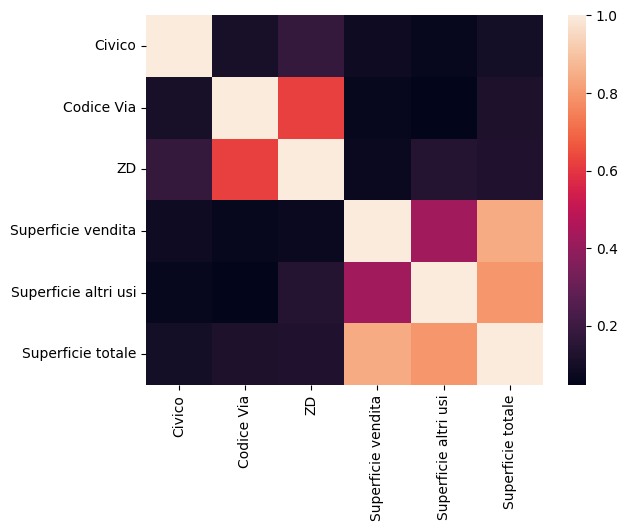

In [15]:
#correlation evaluation heatmap
sns.heatmap(corr)
plt.show()

Histogram for Settore Merceologico:


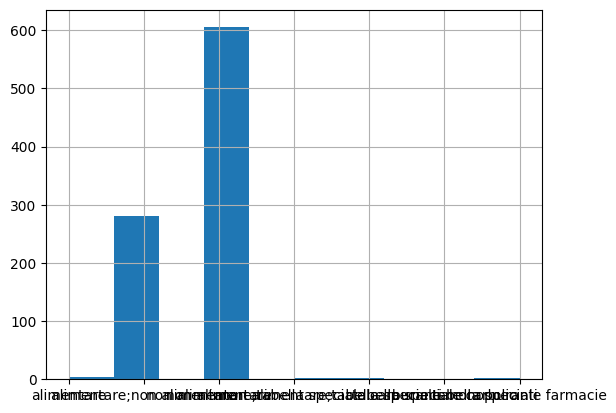

Histogram for Insegna:


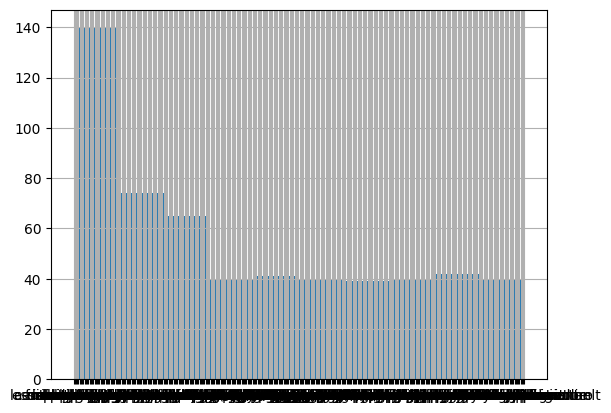

Histogram for Ubicazione:


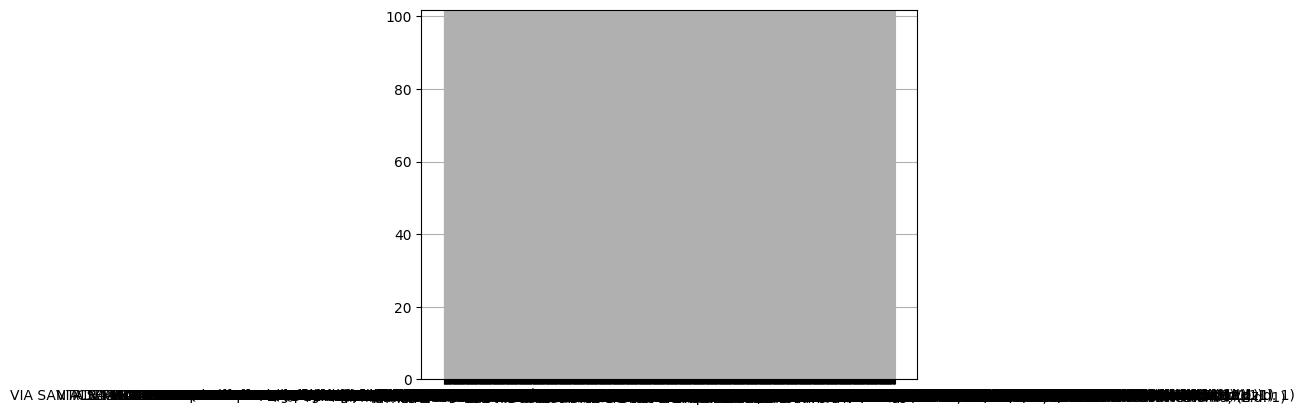

Histogram for Tipo Via:


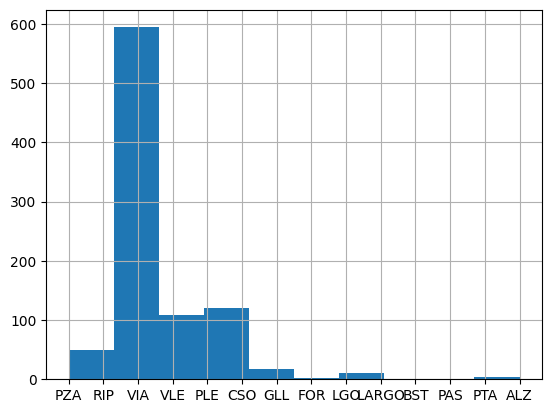

Histogram for Via:


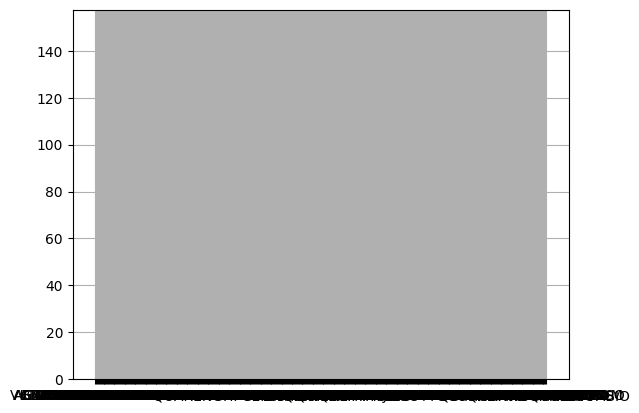

Histogram for Civico:


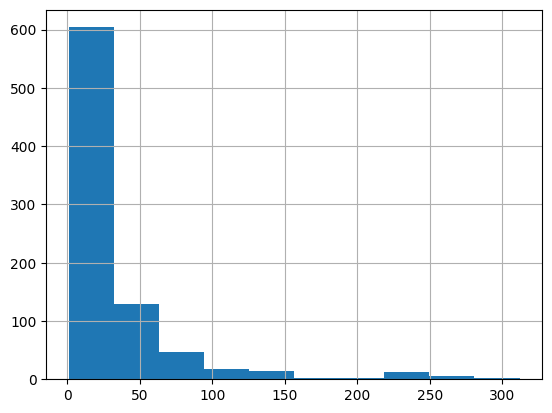

Histogram for Codice Via:


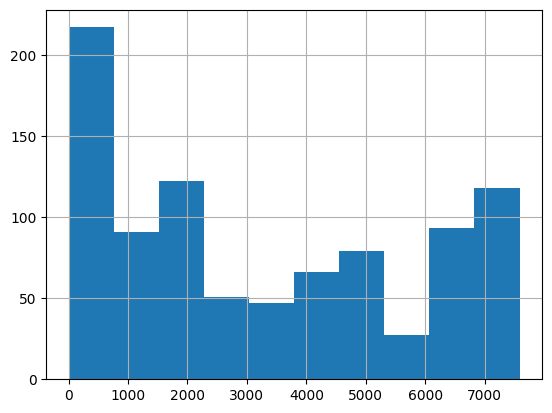

Histogram for ZD:


Histogram for Superficie vendita:


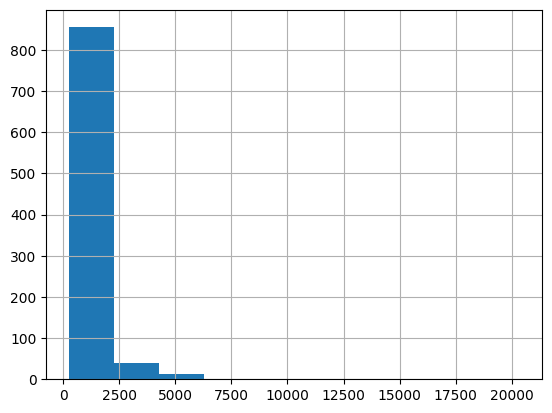

Histogram for Superficie altri usi:


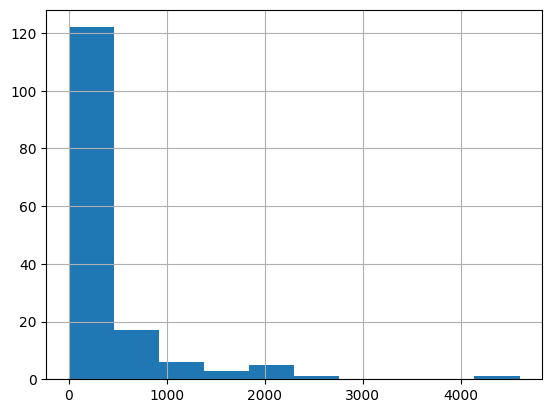

Histogram for Superficie totale:


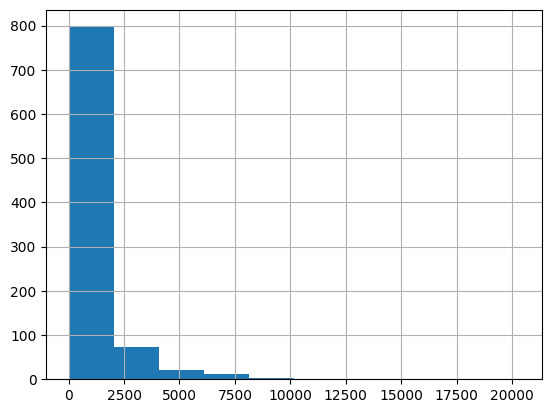

In [16]:
#plots for each column distribution
for col in DATA.columns:
    print("Histogram for "+col+":")
    DATA[col].hist()
    plt.show()

In [17]:
#profile report
PROFILE = ProfileReport(DATA, title="Pandas Profiling Report")
PROFILE

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

2)DQ ASSESSMENT

In [18]:
#Considering that Milan has zones from 1 to 9, ZONES_OF_MILAN is created and then used as a sort
#of "additional source" to evaluate the accuracy for the column ZD
data = { 'ZD' : [1,2,3,4,5,6,7,8,9]}
ZONES_OF_MILAN =  pd.DataFrame(data)
ZONES_OF_MILAN

ZD
0   1
1   2
2   3
3   4
4   5
5   6
6   7
7   8
8   9

In [19]:
#data quality assessment for each column
for col in DATA.columns:
    print("DQ Assessment for "+col+":")

    DISTINCT = (DATA[col].nunique())
    COUNT = DATA[col].count()
    ROWS = len(DATA[col])
    UNIQUENESS = DISTINCT / ROWS
    print("UNIQUENESS: ", UNIQUENESS)

    DISTINCTNESS = DISTINCT / COUNT
    print("DISTINCTNESS: ", DISTINCTNESS)

    MAX_COUNTS = max(DATA[col].value_counts())
    CONSTANCY = MAX_COUNTS / COUNT
    print("CONSTANCY: ", CONSTANCY)

    #completeness evaluation at attribute level (completeness of the single column)
    NOT_NULL = DATA[col].count().sum()
    NULL = DATA[col].isnull().sum().sum()
    TOT = DATA[col].shape[0]
    COMPLETENESS = NOT_NULL / TOT
    print("COMPLETENESS: ", COMPLETENESS)

    #accuracy for attribute 'ZD' using ZONES_OF_MILAN to evaluate it
    if col == 'ZD' :
      CORRECT = DATA['ZD'].isin(ZONES_OF_MILAN['ZD'])
      CORRECT_ZD = np.sum(CORRECT)
      NOT_NULL_ZD = DATA['ZD'].count()
      ACCURACY = CORRECT_ZD/NOT_NULL_ZD
      print("ZD ACCURACY: ", ACCURACY)

    print("\n\n")

DQ Assessment for Settore Merceologico:
UNIQUENESS:  0.007683863885839737
DISTINCTNESS:  0.00778642936596218
CONSTANCY:  0.6729699666295884
COMPLETENESS:  0.986827661909989



DQ Assessment for Insegna:
UNIQUENESS:  0.40175631174533477
DISTINCTNESS:  0.6524064171122995
CONSTANCY:  0.053475935828877004
COMPLETENESS:  0.6158068057080132



DQ Assessment for Ubicazione:
UNIQUENESS:  0.9538968166849616
DISTINCTNESS:  0.9538968166849616
CONSTANCY:  0.0043907793633369925
COMPLETENESS:  1.0



DQ Assessment for Tipo Via:
UNIQUENESS:  0.015367727771679473
DISTINCTNESS:  0.015367727771679473
CONSTANCY:  0.6520307354555434
COMPLETENESS:  1.0



DQ Assessment for Via:
UNIQUENESS:  0.5433589462129528
DISTINCTNESS:  0.5433589462129528
CONSTANCY:  0.02854006586169045
COMPLETENESS:  1.0



DQ Assessment for Civico:
UNIQUENESS:  0.132821075740944
DISTINCTNESS:  0.14421930870083433
CONSTANCY:  0.08343265792610251
COMPLETENESS:  0.9209659714599341



DQ Assessment for Codice Via:
UNIQUENESS:  0.54994511

In [20]:
#Evaluation of completeness at table level (whole dataset)
NOT_NULL = DATA.count().sum()
NULL = DATA.isnull().sum().sum()
TOT = DATA.shape[0]*DATA.shape[1]
COMPLETENESS = NOT_NULL / TOT
print("COMPLETENESS of the whole dataset: ", COMPLETENESS)

COMPLETENESS of the whole dataset:  0.8812493763097495


In [21]:
#consistency evaluated with respect to a rule according to which the sum of 'Superficie vendita' and
# 'Superficie altri usi' should be equal to 'Superficie totale'
DATA['consistency'] = np.where(DATA['Superficie totale'] == (DATA['Superficie vendita'] + DATA['Superficie altri usi']) , 1, 0)
CONSISTENT = DATA['consistency'].sum()
COUNT = DATA['consistency'].count()
CONSISTENCY = CONSISTENT/COUNT
DATA = DATA.drop(columns= ["consistency"])
print("CONSISTENCY: ", CONSISTENCY)

CONSISTENCY:  0.15806805708013172


In [22]:
#presence of exact duplicates
DATA.duplicated().any()

True

In [23]:
#function duplicated returns a boolean Series denoting the duplicate rows (exact matching)
DUPLICATES = DATA.duplicated()
DUPLICATES

0      False
1      False
2      False
3      False
4      False
       ...  
906    False
907    False
908    False
909    False
910    False
Length: 911, dtype: bool

3)DATA CLEANING (DATA TRANSFORMATION)

In [24]:
#columns of the dataset
DATA.columns

Index(['Settore Merceologico', 'Insegna', 'Ubicazione', 'Tipo Via', 'Via',
       'Civico', 'Codice Via', 'ZD', 'Superficie vendita',
       'Superficie altri usi', 'Superficie totale'],
      dtype='object')

In [25]:
#renaming of columns containing blank spaces and "standardization" of the use of capital letters in names
DATA = DATA.rename(columns={'Tipo Via': 'TipoVia', 'Superficie totale': 'SuperficieTotale','Superficie vendita': 'SuperficieVendita',
                            'Superficie altri usi': 'SuperficieAltriUsi','Codice Via': 'CodiceVia','Settore Merceologico': 'SettoreMerceologico'})
DATA

SettoreMerceologico              Insegna  \
0                                          NaN                  NaN   
1                                          NaN                  NaN   
2                                          NaN                  NaN   
3                                          NaN                  NaN   
4                                          NaN                  NaN   
..                                         ...                  ...   
906  non alimentare;tabella speciale monopolio                  NaN   
907                tabella speciale carburanti                  NaN   
908                  tabella speciale farmacie             farmacia   
909                  tabella speciale farmacie  farmacia cassiodoro   
910                  tabella speciale farmacie     farmacia scevola   

                                            Ubicazione TipoVia  \
0    PZA CORDUSIO N. 2 ;pza cordusio 002; isolato:4...     PZA   
1                   RIP DI PTA TICINESE N. 73 (z.d. 1)     RIP   
2               VIA ALBERICO DA ROSCIATE N. 5 (z.d. 7)     VIA   
3    VIA ASTESANI ALESSANDRO N. 17 ; isolato:100; a...     VIA   
4              VIA MONTE NAPOLEONE num.006/a; (z.d. 1)     VIA   
..                                                 ...     ...   
906  VIA MACCHI MAURO N. 42 ; isolato:031; accesso:...     VIA   
907  VIA GALLARATE N. 40 centro strada; isolato:228...     VIA   
908  ff porta g codvia 9403 num.000 ; isolato:259; ...     VIA   
909  VLE CASSIODORO N. 12 ; isolato:151; accesso: a...     VLE   
910  VLE TESTI FULVIO N. 90 ; isolato:145; accesso:...     VLE   

                      Via  Civico  CodiceVia  ZD  SuperficieVendita  \
0                CORDUSIO     2.0        626   1                292   
1         DI PTA TICINESE    73.0       5150   6                800   
2    ALBERICO DA ROSCIATE     5.0       6589   7                726   
3     ASTESANI ALESSANDRO    17.0       1558   9                370   
4         MONTE NAPOLEONE     NaN        219   1                270   
..                    ...     ...        ...  ..                ...   
906          MACCHI MAURO    42.0       2133   2                350   
907             GALLARATE    40.0       7420   8                800   
908      MAFFUCCI ANGIOLO    40.0       1276   9                462   
909            CASSIODORO    12.0       6359   8                591   
910          TESTI FULVIO    90.0       1441   9                397   

     SuperficieAltriUsi  SuperficieTotale  
0                   NaN               292  
1                   NaN               800  
2                   NaN                 0  
3                   NaN               370  
4                   NaN               270  
..                  ...               ...  
906               475.0               825  
907               100.0               900  
908                 NaN               753  
909                 NaN               776  
910                 NaN               624  

[911 rows x 11 columns]

In [26]:
#values in 'TipoVia'
DATA['TipoVia'].unique()

array(['PZA', 'RIP', 'VIA', 'VLE', 'PLE', 'CSO', 'GLL', 'FOR', 'LGO',
       'LARGO', 'BST', 'PAS', 'PTA', 'ALZ'], dtype=object)

In [27]:
#Abbreviations are replaced with the corresponding complete word (in the 'TipoVia' column)
DATA.loc[DATA['TipoVia'] == 'PZA', 'TipoVia'] = 'Piazza'
DATA.loc[DATA['TipoVia'] == 'RIP', 'TipoVia'] = 'Ripa'
DATA.loc[DATA['TipoVia'] == 'VIA', 'TipoVia'] = 'Via'
DATA.loc[DATA['TipoVia'] == 'VLE', 'TipoVia'] = 'Viale'
DATA.loc[DATA['TipoVia'] == 'PLE', 'TipoVia'] = 'Piazzale'
DATA.loc[DATA['TipoVia'] == 'CSO', 'TipoVia'] = 'Corso'
DATA.loc[DATA['TipoVia'] == 'GLL', 'TipoVia'] = 'Galleria'
DATA.loc[DATA['TipoVia'] == 'FOR', 'TipoVia'] = 'Foro'
DATA.loc[DATA['TipoVia'] == 'LGO', 'TipoVia'] = 'Largo'
DATA.loc[DATA['TipoVia'] == 'LARGO', 'TipoVia'] = 'Largo'
DATA.loc[DATA['TipoVia'] == 'BST', 'TipoVia'] = 'Bastioni'
DATA.loc[DATA['TipoVia'] == 'PAS', 'TipoVia'] = 'Passaggio'
DATA.loc[DATA['TipoVia'] == 'PTA', 'TipoVia'] = 'Piazzetta'
DATA.loc[DATA['TipoVia'] == 'ALZ', 'TipoVia'] = 'Alzaia'

In [28]:
#list of distinct values in 'SettoreMerceologico'
DATA['SettoreMerceologico'].unique()

array([nan, 'alimentare', 'alimentare;non alimentare', 'non alimentare',
       'non alimentare;tabella speciale carburanti',
       'non alimentare;tabella speciale monopolio',
       'tabella speciale carburanti', 'tabella speciale farmacie'],
      dtype=object)

In [29]:
#analysis of some tuples containing value 'alimentare;non alimentare' in 'SettoreMerceologico'
#It's used without a specific criteria, since it's used also for toys shops or clothes shops, which don't sell food.
#we decide to consider it as a sort of "non specializzato"
DATA[(DATA['SettoreMerceologico'] == 'alimentare;non alimentare')].tail(30)

SettoreMerceologico                   Insegna  \
267  alimentare;non alimentare      supermercati di x di   
268  alimentare;non alimentare              supermercato   
269  alimentare;non alimentare         suprmercato dufry   
270  alimentare;non alimentare                team point   
271  alimentare;non alimentare               toys center   
272  alimentare;non alimentare               toys center   
273  alimentare;non alimentare               toys center   
274  alimentare;non alimentare                      unes   
275  alimentare;non alimentare                      unes   
276  alimentare;non alimentare                      unes   
277  alimentare;non alimentare                      unes   
278  alimentare;non alimentare                      unes   
279  alimentare;non alimentare                      unes   
280  alimentare;non alimentare                      unes   
281  alimentare;non alimentare                      unes   
282  alimentare;non alimentare                      unes   
283  alimentare;non alimentare         unes supermercati   
284  alimentare;non alimentare         unes supermercati   
285  alimentare;non alimentare  unes  u! come tu mi vuoi   
286  alimentare;non alimentare                      upim   
287  alimentare;non alimentare                      upim   
288  alimentare;non alimentare                      upim   
289  alimentare;non alimentare                      upim   
290  alimentare;non alimentare                      upim   
291  alimentare;non alimentare                      upim   
292  alimentare;non alimentare                      upim   
293  alimentare;non alimentare                      upim   
294  alimentare;non alimentare                  upim sma   
295  alimentare;non alimentare                  upim sma   
296  alimentare;non alimentare                   versace   

                                            Ubicazione   TipoVia  \
267  VIA SARPI FRA' PAOLO N. 41 ; isolato:109; acce...       Via   
268  VIA CANONICA LUIGI N. 54 ; isolato:106; access...       Via   
269  PZA DUCA D'AOSTA int.staz.centrale 1�interrato...    Piazza   
270  VLE RICHARD GIULIO N. 5 spaccio interno; isola...     Viale   
271  VIA MACCHI MAURO N. 29 ; isolato:039; accesso:...       Via   
272  VIA NOVARA num.083; isolato:044; accesso: acce...       Via   
273  VIA PITAGORA N. 4 ; isolato:024; accesso: acce...       Via   
274  PLE CHIESA DAMIANO N. 2 ; isolato:039; accesso...  Piazzale   
275  VIA DE MARCHI EMILIO N. 10 ; accesso: accesso ...       Via   
276  VIA DURAZZO N. 5 ; isolato:067; accesso: acces...       Via   
277  VIA MURATORI LODOVICO N. 27 ; isolato:166; acc...       Via   
278  VIA SPALLANZANI LAZZARO N. 10 ang. via melzo; ...       Via   
279  VIA TRILUSSA N. 26 ; isolato:063; accesso: acc...       Via   
280  VIA VALLAZZE N. 87 ; isolato:035; accesso: acc...       Via   
281  VIA VARESINA N. 92 ; isolato:237; accesso: acc...       Via   
282  VLE BELISARIO N. 3 ; isolato:165; accesso: acc...     Viale   
283  VIA MINERBI ARRIGO N. 1 ; isolato:075; accesso...       Via   
284  VIA VAL DI SOLE N. 12 ; isolato:166; accesso: ...       Via   
285  VIA VALLAZZE N. 104 ; accesso: accesso esterno...       Via   
286  CSO BUENOS AIRES N. 21 ; isolato:078; accesso:...     Corso   
287  PLE LORETO N. 5 ; isolato:357; accesso: access...  Piazzale   
288  PZA FRATTINI PIETRO num.008; isolato:124; acce...    Piazza   
289  VIA CUNEO N. 2 ; isolato:214; accesso: accesso...       Via   
290  VIA FARINI CARLO N. 79 ; isolato:153; accesso:...       Via   
291  VIA MANCINI LODOVICO N. 2 ; isolato:035; acces...       Via   
292  VIA POLESINE N. 39 ; isolato:055; accesso: acc...       Via   
293  VIA SPADARI N. 2 ;via spadari 002; isolato:438...       Via   
294  CSO SAN GOTTARDO num.029/31; isolato:095; acce...     Corso   
295  VIA MASOLINO DA PANICALE N. 7 ; isolato:300; a...       Via   
296  VIA MONTE NAPOLEONE N. 11 ;via monte napoleone...       Via   

                      Via  Civico  Codice

In [30]:
#Standardization of 'SettoreMerceologico' values
DATA.loc[DATA['SettoreMerceologico'] == 'tabella speciale farmacie', 'SettoreMerceologico'] = 'Settore farmaceutico'
DATA.loc[DATA['SettoreMerceologico'] == 'tabella speciale carburanti', 'SettoreMerceologico'] = 'Settore carburanti'
DATA.loc[DATA['SettoreMerceologico'] == 'non alimentare;tabella speciale carburanti', 'SettoreMerceologico'] = 'Settore carburanti'
DATA.loc[DATA['SettoreMerceologico'] == 'alimentare', 'SettoreMerceologico'] = 'Settore alimentare'
DATA.loc[DATA['SettoreMerceologico'] == 'non alimentare', 'SettoreMerceologico'] = 'Settore non alimentare'
DATA.loc[DATA['SettoreMerceologico'] == 'alimentare;non alimentare', 'SettoreMerceologico'] = 'Non specializzato'
DATA.loc[DATA['SettoreMerceologico'] == 'non alimentare;tabella speciale monopolio', 'SettoreMerceologico'] = 'Settore di monopolio'

In [31]:
DATA['SettoreMerceologico'].unique()

array([nan, 'Settore alimentare', 'Non specializzato',
       'Settore non alimentare', 'Settore carburanti',
       'Settore di monopolio', 'Settore farmaceutico'], dtype=object)

In [32]:
DATA['Insegna'].unique()

array([nan, 'esselunga', 'in s mercato', 'la rinascente s.p.a.', 'pam',
       'supermarket', 'punto sma', 'acquazzurra', 'benetton',
       'blockbuster', 'botanic', 'carrefour', 'centro botanico',
       'centro sposi paradiso', 'cityper sma', 'coin', 'conad', 'coop',
       'crai', 'decathlon', 'dico', 'di perdi', 'di  per di', 'di per di',
       'discount', 'di  x di', 'di x di il supermercato', 'dugan', 'ecom',
       'esselunga centro commerci', 'esselunga spa.',
       'esselunga vle certosa', 'esselunga vle jenner', 'euro discount',
       'filzi market', 'fnac e standa superfresco', 'free shop', 'gs',
       'gs supermercato', 'il gigante', 'il mercatino di via arbe',
       'io brico', 'ipercoop', 'iper portello', 'iperstanda', 'italbar',
       'kathay china food store', 'la coloniale', 'ld discount',
       'ld market', 'licenza madre ce de angel',
       'licenza madre ce palizzi', 'lidl', 'lidl supermarket',
       'longoni sport punto giall', 'messaggerie musicali',
   

In [33]:
#creation of a temporary dataset used to detect typos in the 'Insegna' field
#only tuples with a not null value in 'Insegna' are inserted in this temporary dataset
DATA2= DATA[DATA['Insegna'].notna()]


In [34]:
#typos detection using Jaro-Winkler metrics
typo_results = detect_typos(DATA2['Insegna'], threshold=0.87)
typo_results

366


[('esselunga',
  [('esselunga centro commerci', 0.872),
   ('esselunga spa.', 0.9285714285714286),
   ('esselunga vle certosa', 0.8857142857142858),
   ('esselunga vle jenner', 0.89)]),
 ('la rinascente s.p.a.', [('la rinascente', 0.9066666666666666)]),
 ('supermarket',
  [('lidl supermarket', 0.8958333333333334),
   ('supermercato', 0.9284848484848485),
   ('supermarket del legno', 0.9047619047619048)]),
 ('punto sma', [('punto market', 0.9111111111111111)]),
 ('crai', [('cai', 0.9249999999999999)]),
 ('di perdi',
  [('di  per di', 0.9466666666666665), ('di per di', 0.9703703703703703)]),
 ('di  per di',
  [('di perdi', 0.9466666666666665),
   ('di per di', 0.914074074074074),
   ('di  x di', 0.8866666666666667)]),
 ('di per di',
  [('di perdi', 0.9703703703703703), ('di  per di', 0.914074074074074)]),
 ('discount',
  [('ld discount', 0.9090909090909092), ('pd discount', 0.9090909090909092)]),
 ('di  x di', [('di  per di', 0.8866666666666667)]),
 ('esselunga centro commerci', [('essel

In [35]:
#some values are manually standardized, using the result of the previous function
insegne = ['max  E  co.', 'max  E  co max mara']
DATA.loc[DATA['Insegna'].isin(insegne), 'Insegna'] = 'max  E  co'
insegne = ['d E g', 'd  E  g.']
DATA.loc[DATA['Insegna'].isin(insegne), 'Insegna'] = 'd. E  g.'
insegne = ['esselunga centro commerci', 'esselunga spa.','esselunga vle certosa', 'esselunga vle jenner']
DATA.loc[DATA['Insegna'].isin(insegne), 'Insegna'] = 'esselunga'
insegne = ['di  per di', 'di perdi', 'di  x di']
DATA.loc[DATA['Insegna'].isin(insegne), 'Insegna'] = 'di per di'
DATA.loc[DATA['Insegna']== 'naturasi', 'Insegna'] = 'natura si'
insegne = ['la rinascente s.p.a.', 'la rinascente duomo']
DATA.loc[DATA['Insegna'].isin(insegne), 'Insegna'] = 'la rinascente'
DATA.loc[DATA['Insegna']== 'sma supermercati alimenta', 'Insegna'] = 'sma supermercati'
DATA.loc[DATA['Insegna']== 'max mara', 'Insegna'] = 'maxmara'
#typos
DATA.loc[DATA['Insegna']== 'ricordi medi store', 'Insegna'] = 'ricordi media store'
DATA.loc[DATA['Insegna']=='mondadori mulitcenter', 'Insegna'] = 'mondadori multicenter'
DATA


SettoreMerceologico              Insegna  \
0                     NaN                  NaN   
1                     NaN                  NaN   
2                     NaN                  NaN   
3                     NaN                  NaN   
4                     NaN                  NaN   
..                    ...                  ...   
906  Settore di monopolio                  NaN   
907    Settore carburanti                  NaN   
908  Settore farmaceutico             farmacia   
909  Settore farmaceutico  farmacia cassiodoro   
910  Settore farmaceutico     farmacia scevola   

                                            Ubicazione TipoVia  \
0    PZA CORDUSIO N. 2 ;pza cordusio 002; isolato:4...  Piazza   
1                   RIP DI PTA TICINESE N. 73 (z.d. 1)    Ripa   
2               VIA ALBERICO DA ROSCIATE N. 5 (z.d. 7)     Via   
3    VIA ASTESANI ALESSANDRO N. 17 ; isolato:100; a...     Via   
4              VIA MONTE NAPOLEONE num.006/a; (z.d. 1)     Via   
..                                                 ...     ...   
906  VIA MACCHI MAURO N. 42 ; isolato:031; accesso:...     Via   
907  VIA GALLARATE N. 40 centro strada; isolato:228...     Via   
908  ff porta g codvia 9403 num.000 ; isolato:259; ...     Via   
909  VLE CASSIODORO N. 12 ; isolato:151; accesso: a...   Viale   
910  VLE TESTI FULVIO N. 90 ; isolato:145; accesso:...   Viale   

                      Via  Civico  CodiceVia  ZD  SuperficieVendita  \
0                CORDUSIO     2.0        626   1                292   
1         DI PTA TICINESE    73.0       5150   6                800   
2    ALBERICO DA ROSCIATE     5.0       6589   7                726   
3     ASTESANI ALESSANDRO    17.0       1558   9                370   
4         MONTE NAPOLEONE     NaN        219   1                270   
..                    ...     ...        ...  ..                ...   
906          MACCHI MAURO    42.0       2133   2                350   
907             GALLARATE    40.0       7420   8                800   
908      MAFFUCCI ANGIOLO    40.0       1276   9                462   
909            CASSIODORO    12.0       6359   8                591   
910          TESTI FULVIO    90.0       1441   9                397   

     SuperficieAltriUsi  SuperficieTotale  
0                   NaN               292  
1                   NaN               800  
2                   NaN                 0  
3                   NaN               370  
4                   NaN               270  
..                  ...               ...  
906               475.0               825  
907               100.0               900  
908                 NaN               753  
909                 NaN               776  
910                 NaN               624  

[911 rows x 11 columns]

In [36]:
DATA['Insegna'].unique()

array([nan, 'esselunga', 'in s mercato', 'la rinascente', 'pam',
       'supermarket', 'punto sma', 'acquazzurra', 'benetton',
       'blockbuster', 'botanic', 'carrefour', 'centro botanico',
       'centro sposi paradiso', 'cityper sma', 'coin', 'conad', 'coop',
       'crai', 'decathlon', 'dico', 'di per di', 'discount',
       'di x di il supermercato', 'dugan', 'ecom', 'euro discount',
       'filzi market', 'fnac e standa superfresco', 'free shop', 'gs',
       'gs supermercato', 'il gigante', 'il mercatino di via arbe',
       'io brico', 'ipercoop', 'iper portello', 'iperstanda', 'italbar',
       'kathay china food store', 'la coloniale', 'ld discount',
       'ld market', 'licenza madre ce de angel',
       'licenza madre ce palizzi', 'lidl', 'lidl supermarket',
       'longoni sport punto giall', 'messaggerie musicali',
       'mondadori multicenter', 'natura si', 'oviesse', 'pd discount',
       'peck', 'penny market', 'playlife', 'punto market', 'quel che c e',
       'salv

In [37]:
DATA['Ubicazione'].unique()

array(['PZA CORDUSIO N. 2 ;pza cordusio 002; isolato:436; accesso: accesso esterno; (z.d. 1)',
       'RIP DI PTA TICINESE N. 73 (z.d. 1)',
       'VIA ALBERICO DA ROSCIATE N. 5 (z.d. 7)',
       'VIA ASTESANI ALESSANDRO N. 17 ; isolato:100; accesso: accesso esterno; (z.d. 8)',
       'VIA MONTE NAPOLEONE num.006/a; (z.d. 1)',
       'VIA ROGOREDO (in cassaforte) num.000; (z.d. 4)',
       'VIA DOMENICHINO N. 2 ; isolato:227; accesso: accesso esterno; (z.d. 7)',
       'VLE VIGLIANI PAOLO ONORATO num.059; isolato:169; accesso: accesso esterno; (z.d. 8)',
       'VIA DELLE BETULLE num.012; isolato:240; accesso: accesso esterno; (z.d. 7)',
       'VIA SANTA RADEGONDA N. 3 11 piani (10 f.t. e 1 int.);via santa radegonda 003; isolato:417; accesso: accesso esterno; (z.d. 1)',
       'VIA PADOVA N. 111 ; isolato:279; accesso: accesso esterno; (z.d. 2)',
       'VIA ROSSI PELLEGRINO N. 33 ; isolato:182; accesso: accesso esterno; (z.d. 9)',
       'PLE SELINUNTE N. 2 int. m.c.c. selinunte; (z.

In [38]:
#extraction of the zone from 'Ubicazione'
DATA[['Ubicazione', 'ZD2']] = DATA.Ubicazione.str.split("z.d. ", n=1, expand=True)
DATA['ZD2'] = DATA['ZD2'].str.replace(')', '')
DATA['Ubicazione'] = DATA['Ubicazione'].str.replace('(', '')
DATA

SettoreMerceologico              Insegna  \
0                     NaN                  NaN   
1                     NaN                  NaN   
2                     NaN                  NaN   
3                     NaN                  NaN   
4                     NaN                  NaN   
..                    ...                  ...   
906  Settore di monopolio                  NaN   
907    Settore carburanti                  NaN   
908  Settore farmaceutico             farmacia   
909  Settore farmaceutico  farmacia cassiodoro   
910  Settore farmaceutico     farmacia scevola   

                                            Ubicazione TipoVia  \
0    PZA CORDUSIO N. 2 ;pza cordusio 002; isolato:4...  Piazza   
1                           RIP DI PTA TICINESE N. 73     Ripa   
2                       VIA ALBERICO DA ROSCIATE N. 5      Via   
3    VIA ASTESANI ALESSANDRO N. 17 ; isolato:100; a...     Via   
4                      VIA MONTE NAPOLEONE num.006/a;      Via   
..                                                 ...     ...   
906  VIA MACCHI MAURO N. 42 ; isolato:031; accesso:...     Via   
907  VIA GALLARATE N. 40 centro strada; isolato:228...     Via   
908  ff porta g codvia 9403 num.000 ; isolato:259; ...     Via   
909  VLE CASSIODORO N. 12 ; isolato:151; accesso: a...   Viale   
910  VLE TESTI FULVIO N. 90 ; isolato:145; accesso:...   Viale   

                      Via  Civico  CodiceVia  ZD  SuperficieVendita  \
0                CORDUSIO     2.0        626   1                292   
1         DI PTA TICINESE    73.0       5150   6                800   
2    ALBERICO DA ROSCIATE     5.0       6589   7                726   
3     ASTESANI ALESSANDRO    17.0       1558   9                370   
4         MONTE NAPOLEONE     NaN        219   1                270   
..                    ...     ...        ...  ..                ...   
906          MACCHI MAURO    42.0       2133   2                350   
907             GALLARATE    40.0       7420   8                800   
908      MAFFUCCI ANGIOLO    40.0       1276   9                462   
909            CASSIODORO    12.0       6359   8                591   
910          TESTI FULVIO    90.0       1441   9                397   

     SuperficieAltriUsi  SuperficieTotale ZD2  
0                   NaN               292   1  
1                   NaN               800   1  
2                   NaN                 0   7  
3                   NaN               370   8  
4                   NaN               270   1  
..                  ...               ...  ..  
906               475.0               825   2  
907               100.0               900   8  
908                 NaN               753   9  
909                 NaN               776   8  
910                 NaN               624   9  

[911 rows x 12 columns]

In [39]:
#extraction of the type of access to the shop from 'Ubicazione'
DATA[['Ubicazione', 'TipoAccesso']] = DATA.Ubicazione.str.split("accesso: ", n=1, expand=True)
DATA['TipoAccesso'] = DATA['TipoAccesso'].str.replace(';', '')
DATA

SettoreMerceologico              Insegna  \
0                     NaN                  NaN   
1                     NaN                  NaN   
2                     NaN                  NaN   
3                     NaN                  NaN   
4                     NaN                  NaN   
..                    ...                  ...   
906  Settore di monopolio                  NaN   
907    Settore carburanti                  NaN   
908  Settore farmaceutico             farmacia   
909  Settore farmaceutico  farmacia cassiodoro   
910  Settore farmaceutico     farmacia scevola   

                                            Ubicazione TipoVia  \
0    PZA CORDUSIO N. 2 ;pza cordusio 002; isolato:4...  Piazza   
1                           RIP DI PTA TICINESE N. 73     Ripa   
2                       VIA ALBERICO DA ROSCIATE N. 5      Via   
3        VIA ASTESANI ALESSANDRO N. 17 ; isolato:100;      Via   
4                      VIA MONTE NAPOLEONE num.006/a;      Via   
..                                                 ...     ...   
906             VIA MACCHI MAURO N. 42 ; isolato:031;      Via   
907  VIA GALLARATE N. 40 centro strada; isolato:228...     Via   
908     ff porta g codvia 9403 num.000 ; isolato:259;      Via   
909               VLE CASSIODORO N. 12 ; isolato:151;    Viale   
910             VLE TESTI FULVIO N. 90 ; isolato:145;    Viale   

                      Via  Civico  CodiceVia  ZD  SuperficieVendita  \
0                CORDUSIO     2.0        626   1                292   
1         DI PTA TICINESE    73.0       5150   6                800   
2    ALBERICO DA ROSCIATE     5.0       6589   7                726   
3     ASTESANI ALESSANDRO    17.0       1558   9                370   
4         MONTE NAPOLEONE     NaN        219   1                270   
..                    ...     ...        ...  ..                ...   
906          MACCHI MAURO    42.0       2133   2                350   
907             GALLARATE    40.0       7420   8                800   
908      MAFFUCCI ANGIOLO    40.0       1276   9                462   
909            CASSIODORO    12.0       6359   8                591   
910          TESTI FULVIO    90.0       1441   9                397   

     SuperficieAltriUsi  SuperficieTotale ZD2       TipoAccesso  
0                   NaN               292   1  accesso esterno   
1                   NaN               800   1              None  
2                   NaN                 0   7              None  
3                   NaN               370   8  accesso esterno   
4                   NaN               270   1              None  
..                  ...               ...  ..               ...  
906               475.0               825   2  accesso interno   
907               100.0               900   8  accesso esterno   
908                 NaN               753   9  accesso interno   
909                 NaN               776   8  accesso esterno   
910                 NaN               624   9  accesso esterno   

[911 rows x 13 columns]

In [40]:
#extraction of the 'PtoStrada' from 'Ubicazione'
DATA[['Ubicazione', 'PtoStrada']] = DATA.Ubicazione.str.split("pto strada:", n=1, expand=True)
DATA['PtoStrada'] = DATA['PtoStrada'].str.replace(';', '')
DATA

SettoreMerceologico              Insegna  \
0                     NaN                  NaN   
1                     NaN                  NaN   
2                     NaN                  NaN   
3                     NaN                  NaN   
4                     NaN                  NaN   
..                    ...                  ...   
906  Settore di monopolio                  NaN   
907    Settore carburanti                  NaN   
908  Settore farmaceutico             farmacia   
909  Settore farmaceutico  farmacia cassiodoro   
910  Settore farmaceutico     farmacia scevola   

                                            Ubicazione TipoVia  \
0    PZA CORDUSIO N. 2 ;pza cordusio 002; isolato:4...  Piazza   
1                           RIP DI PTA TICINESE N. 73     Ripa   
2                       VIA ALBERICO DA ROSCIATE N. 5      Via   
3        VIA ASTESANI ALESSANDRO N. 17 ; isolato:100;      Via   
4                      VIA MONTE NAPOLEONE num.006/a;      Via   
..                                                 ...     ...   
906             VIA MACCHI MAURO N. 42 ; isolato:031;      Via   
907   VIA GALLARATE N. 40 centro strada; isolato:228;      Via   
908     ff porta g codvia 9403 num.000 ; isolato:259;      Via   
909               VLE CASSIODORO N. 12 ; isolato:151;    Viale   
910             VLE TESTI FULVIO N. 90 ; isolato:145;    Viale   

                      Via  Civico  CodiceVia  ZD  SuperficieVendita  \
0                CORDUSIO     2.0        626   1                292   
1         DI PTA TICINESE    73.0       5150   6                800   
2    ALBERICO DA ROSCIATE     5.0       6589   7                726   
3     ASTESANI ALESSANDRO    17.0       1558   9                370   
4         MONTE NAPOLEONE     NaN        219   1                270   
..                    ...     ...        ...  ..                ...   
906          MACCHI MAURO    42.0       2133   2                350   
907             GALLARATE    40.0       7420   8                800   
908      MAFFUCCI ANGIOLO    40.0       1276   9                462   
909            CASSIODORO    12.0       6359   8                591   
910          TESTI FULVIO    90.0       1441   9                397   

     SuperficieAltriUsi  SuperficieTotale ZD2       TipoAccesso PtoStrada  
0                   NaN               292   1  accesso esterno       None  
1                   NaN               800   1              None      None  
2                   NaN                 0   7              None      None  
3                   NaN               370   8  accesso esterno       None  
4                   NaN               270   1              None      None  
..                  ...               ...  ..               ...       ...  
906               475.0               825   2  accesso interno       None  
907               100.0               900   8  accesso esterno        cs   
908                 NaN               753   9  accesso interno       None  
909                 NaN               776   8  accesso esterno       None  
910                 NaN               624   9  accesso esterno       None  

[911 rows x 14 columns]

In [41]:
#extraction of the isolato from 'Ubicazione'
DATA[['Ubicazione', 'Isolato']] = DATA.Ubicazione.str.split("isolato:", n=1, expand=True)
DATA['Isolato'] = DATA['Isolato'].str.replace(';', '')
DATA

SettoreMerceologico              Insegna  \
0                     NaN                  NaN   
1                     NaN                  NaN   
2                     NaN                  NaN   
3                     NaN                  NaN   
4                     NaN                  NaN   
..                    ...                  ...   
906  Settore di monopolio                  NaN   
907    Settore carburanti                  NaN   
908  Settore farmaceutico             farmacia   
909  Settore farmaceutico  farmacia cassiodoro   
910  Settore farmaceutico     farmacia scevola   

                                Ubicazione TipoVia                   Via  \
0    PZA CORDUSIO N. 2 ;pza cordusio 002;   Piazza              CORDUSIO   
1               RIP DI PTA TICINESE N. 73     Ripa       DI PTA TICINESE   
2           VIA ALBERICO DA ROSCIATE N. 5      Via  ALBERICO DA ROSCIATE   
3         VIA ASTESANI ALESSANDRO N. 17 ;      Via   ASTESANI ALESSANDRO   
4          VIA MONTE NAPOLEONE num.006/a;      Via       MONTE NAPOLEONE   
..                                     ...     ...                   ...   
906              VIA MACCHI MAURO N. 42 ;      Via          MACCHI MAURO   
907    VIA GALLARATE N. 40 centro strada;      Via             GALLARATE   
908      ff porta g codvia 9403 num.000 ;      Via      MAFFUCCI ANGIOLO   
909                VLE CASSIODORO N. 12 ;    Viale            CASSIODORO   
910              VLE TESTI FULVIO N. 90 ;    Viale          TESTI FULVIO   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
0       2.0        626   1                292                 NaN   
1      73.0       5150   6                800                 NaN   
2       5.0       6589   7                726                 NaN   
3      17.0       1558   9                370                 NaN   
4       NaN        219   1                270                 NaN   
..      ...        ...  ..                ...                 ...   
906    42.0       2133   2                350               475.0   
907    40.0       7420   8                800               100.0   
908    40.0       1276   9                462                 NaN   
909    12.0       6359   8                591                 NaN   
910    90.0       1441   9                397                 NaN   

     SuperficieTotale ZD2       TipoAccesso PtoStrada Isolato  
0                 292   1  accesso esterno       None    436   
1                 800   1              None      None    None  
2                   0   7              None      None    None  
3                 370   8  accesso esterno       None    100   
4                 270   1              None      None    None  
..                ...  ..               ...       ...     ...  
906               825   2  accesso interno       None    031   
907               900   8  accesso esterno        cs     228   
908               753   9  accesso interno       None    259   
909               776   8  accesso esterno       None    151   
910               624   9  accesso esterno       None    145   

[911 rows x 15 columns]

In [42]:
#replacing 'num.' with 'N.' in order to prepare the field 'Ubicazione' for the extraction of
#the civic number
DATA[['Ubicazione', 'Ubicazione2']] = DATA.Ubicazione.str.split(";", n=1, expand=True)
DATA['Ubicazione'] = DATA['Ubicazione'].str.replace('num.', 'N. ')
#extraction of the civic number from 'Ubicazione'
DATA[['Ubicazione', 'Civico2']] = DATA.Ubicazione.str.split(" N. ", n=1, expand=True)
DATA

SettoreMerceologico              Insegna                Ubicazione  \
0                     NaN                  NaN              PZA CORDUSIO   
1                     NaN                  NaN       RIP DI PTA TICINESE   
2                     NaN                  NaN  VIA ALBERICO DA ROSCIATE   
3                     NaN                  NaN   VIA ASTESANI ALESSANDRO   
4                     NaN                  NaN       VIA MONTE NAPOLEONE   
..                    ...                  ...                       ...   
906  Settore di monopolio                  NaN          VIA MACCHI MAURO   
907    Settore carburanti                  NaN             VIA GALLARATE   
908  Settore farmaceutico             farmacia    ff porta g codvia 9403   
909  Settore farmaceutico  farmacia cassiodoro            VLE CASSIODORO   
910  Settore farmaceutico     farmacia scevola          VLE TESTI FULVIO   

    TipoVia                   Via  Civico  CodiceVia  ZD  SuperficieVendita  \
0    Piazza              CORDUSIO     2.0        626   1                292   
1      Ripa       DI PTA TICINESE    73.0       5150   6                800   
2       Via  ALBERICO DA ROSCIATE     5.0       6589   7                726   
3       Via   ASTESANI ALESSANDRO    17.0       1558   9                370   
4       Via       MONTE NAPOLEONE     NaN        219   1                270   
..      ...                   ...     ...        ...  ..                ...   
906     Via          MACCHI MAURO    42.0       2133   2                350   
907     Via             GALLARATE    40.0       7420   8                800   
908     Via      MAFFUCCI ANGIOLO    40.0       1276   9                462   
909   Viale            CASSIODORO    12.0       6359   8                591   
910   Viale          TESTI FULVIO    90.0       1441   9                397   

     SuperficieAltriUsi  SuperficieTotale ZD2       TipoAccesso PtoStrada  \
0                   NaN               292   1  accesso esterno       None   
1                   NaN               800   1              None      None   
2                   NaN                 0   7              None      None   
3                   NaN               370   8  accesso esterno       None   
4                   NaN               270   1              None      None   
..                  ...               ...  ..               ...       ...   
906               475.0               825   2  accesso interno       None   
907               100.0               900   8  accesso esterno        cs    
908                 NaN               753   9  accesso interno       None   
909                 NaN               776   8  accesso esterno       None   
910                 NaN               624   9  accesso esterno       None   

    Isolato         Ubicazione2           Civico2  
0      436   pza cordusio 002;                 2   
1      None                None               73   
2      None                None                5   
3      100                                    17   
4      None                                 006/a  
..      ...                 ...               ...  
906    031                                    42   
907    228                       40 centro strada  
908    259                                   000   
909    151                                    12   
910    145                                    90   

[911 rows x 17 columns]

In [43]:
#everything that is not the civic number is "extracted" from 'Civico2'
DATA[['Civico2', 'Ubicazione3']] = DATA.Civico2.str.split(" ", n=1, expand=True)
DATA

SettoreMerceologico              Insegna                Ubicazione  \
0                     NaN                  NaN              PZA CORDUSIO   
1                     NaN                  NaN       RIP DI PTA TICINESE   
2                     NaN                  NaN  VIA ALBERICO DA ROSCIATE   
3                     NaN                  NaN   VIA ASTESANI ALESSANDRO   
4                     NaN                  NaN       VIA MONTE NAPOLEONE   
..                    ...                  ...                       ...   
906  Settore di monopolio                  NaN          VIA MACCHI MAURO   
907    Settore carburanti                  NaN             VIA GALLARATE   
908  Settore farmaceutico             farmacia    ff porta g codvia 9403   
909  Settore farmaceutico  farmacia cassiodoro            VLE CASSIODORO   
910  Settore farmaceutico     farmacia scevola          VLE TESTI FULVIO   

    TipoVia                   Via  Civico  CodiceVia  ZD  SuperficieVendita  \
0    Piazza              CORDUSIO     2.0        626   1                292   
1      Ripa       DI PTA TICINESE    73.0       5150   6                800   
2       Via  ALBERICO DA ROSCIATE     5.0       6589   7                726   
3       Via   ASTESANI ALESSANDRO    17.0       1558   9                370   
4       Via       MONTE NAPOLEONE     NaN        219   1                270   
..      ...                   ...     ...        ...  ..                ...   
906     Via          MACCHI MAURO    42.0       2133   2                350   
907     Via             GALLARATE    40.0       7420   8                800   
908     Via      MAFFUCCI ANGIOLO    40.0       1276   9                462   
909   Viale            CASSIODORO    12.0       6359   8                591   
910   Viale          TESTI FULVIO    90.0       1441   9                397   

     SuperficieAltriUsi  SuperficieTotale ZD2       TipoAccesso PtoStrada  \
0                   NaN               292   1  accesso esterno       None   
1                   NaN               800   1              None      None   
2                   NaN                 0   7              None      None   
3                   NaN               370   8  accesso esterno       None   
4                   NaN               270   1              None      None   
..                  ...               ...  ..               ...       ...   
906               475.0               825   2  accesso interno       None   
907               100.0               900   8  accesso esterno        cs    
908                 NaN               753   9  accesso interno       None   
909                 NaN               776   8  accesso esterno       None   
910                 NaN               624   9  accesso esterno       None   

    Isolato         Ubicazione2 Civico2    Ubicazione3  
0      436   pza cordusio 002;        2                 
1      None                None      73                 
2      None                None       5                 
3      100                           17                 
4      None                       006/a           None  
..      ...                 ...     ...            ...  
906    031                           42                 
907    228                           40  centro strada  
908    259                          000                 
909    151                           12                 
910    145                           90                 

[911 rows x 18 columns]

In [44]:
#evaluation of null values in the various columns
DATA.isnull().sum()

SettoreMerceologico     12
Insegna                350
Ubicazione               0
TipoVia                  0
Via                      0
Civico                  72
CodiceVia                0
ZD                       0
SuperficieVendita        0
SuperficieAltriUsi     756
SuperficieTotale         0
ZD2                      0
TipoAccesso             91
PtoStrada              906
Isolato                107
Ubicazione2             52
Civico2                  0
Ubicazione3            107
dtype: int64

In [45]:
#Ubicazione2 and Ubicazione3 are dropped because they contain non-standardizable data
#Ubicazione is dropped because it contains the 'Via' of the shop, which is already present for each tuple
#PtoStrada is dropped because the field is null for 906 tuples
#ZD2 is dropped because every tuple has already a value in ZD
DATA= DATA.drop(columns=["Ubicazione2", "Ubicazione3","Ubicazione","PtoStrada","ZD2"])
DATA

SettoreMerceologico              Insegna TipoVia                   Via  \
0                     NaN                  NaN  Piazza              CORDUSIO   
1                     NaN                  NaN    Ripa       DI PTA TICINESE   
2                     NaN                  NaN     Via  ALBERICO DA ROSCIATE   
3                     NaN                  NaN     Via   ASTESANI ALESSANDRO   
4                     NaN                  NaN     Via       MONTE NAPOLEONE   
..                    ...                  ...     ...                   ...   
906  Settore di monopolio                  NaN     Via          MACCHI MAURO   
907    Settore carburanti                  NaN     Via             GALLARATE   
908  Settore farmaceutico             farmacia     Via      MAFFUCCI ANGIOLO   
909  Settore farmaceutico  farmacia cassiodoro   Viale            CASSIODORO   
910  Settore farmaceutico     farmacia scevola   Viale          TESTI FULVIO   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
0       2.0        626   1                292                 NaN   
1      73.0       5150   6                800                 NaN   
2       5.0       6589   7                726                 NaN   
3      17.0       1558   9                370                 NaN   
4       NaN        219   1                270                 NaN   
..      ...        ...  ..                ...                 ...   
906    42.0       2133   2                350               475.0   
907    40.0       7420   8                800               100.0   
908    40.0       1276   9                462                 NaN   
909    12.0       6359   8                591                 NaN   
910    90.0       1441   9                397                 NaN   

     SuperficieTotale       TipoAccesso Isolato Civico2  
0                 292  accesso esterno     436        2  
1                 800              None    None      73  
2                   0              None    None       5  
3                 370  accesso esterno     100       17  
4                 270              None    None   006/a  
..                ...               ...     ...     ...  
906               825  accesso interno     031       42  
907               900  accesso esterno     228       40  
908               753  accesso interno     259      000  
909               776  accesso esterno     151       12  
910               624  accesso esterno     145       90  

[911 rows x 13 columns]

In [46]:
DATA.dtypes

SettoreMerceologico     object
Insegna                 object
TipoVia                 object
Via                     object
Civico                 float64
CodiceVia                int64
ZD                       int64
SuperficieVendita        int64
SuperficieAltriUsi     float64
SuperficieTotale         int64
TipoAccesso             object
Isolato                 object
Civico2                 object
dtype: object

In [47]:
#SuperficieTotale and SuperficieVendita are cast to float64
DATA["SuperficieVendita"] = DATA["SuperficieVendita"].astype("float64")
DATA["SuperficieTotale"] = DATA["SuperficieTotale"].astype("float64")
DATA

SettoreMerceologico              Insegna TipoVia                   Via  \
0                     NaN                  NaN  Piazza              CORDUSIO   
1                     NaN                  NaN    Ripa       DI PTA TICINESE   
2                     NaN                  NaN     Via  ALBERICO DA ROSCIATE   
3                     NaN                  NaN     Via   ASTESANI ALESSANDRO   
4                     NaN                  NaN     Via       MONTE NAPOLEONE   
..                    ...                  ...     ...                   ...   
906  Settore di monopolio                  NaN     Via          MACCHI MAURO   
907    Settore carburanti                  NaN     Via             GALLARATE   
908  Settore farmaceutico             farmacia     Via      MAFFUCCI ANGIOLO   
909  Settore farmaceutico  farmacia cassiodoro   Viale            CASSIODORO   
910  Settore farmaceutico     farmacia scevola   Viale          TESTI FULVIO   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
0       2.0        626   1              292.0                 NaN   
1      73.0       5150   6              800.0                 NaN   
2       5.0       6589   7              726.0                 NaN   
3      17.0       1558   9              370.0                 NaN   
4       NaN        219   1              270.0                 NaN   
..      ...        ...  ..                ...                 ...   
906    42.0       2133   2              350.0               475.0   
907    40.0       7420   8              800.0               100.0   
908    40.0       1276   9              462.0                 NaN   
909    12.0       6359   8              591.0                 NaN   
910    90.0       1441   9              397.0                 NaN   

     SuperficieTotale       TipoAccesso Isolato Civico2  
0               292.0  accesso esterno     436        2  
1               800.0              None    None      73  
2                 0.0              None    None       5  
3               370.0  accesso esterno     100       17  
4               270.0              None    None   006/a  
..                ...               ...     ...     ...  
906             825.0  accesso interno     031       42  
907             900.0  accesso esterno     228       40  
908             753.0  accesso interno     259      000  
909             776.0  accesso esterno     151       12  
910             624.0  accesso esterno     145       90  

[911 rows x 13 columns]

In [48]:
#analysis of values in 'Civico2'
#It's not easy to understand the meaning of the '/'. It appears to indicate (sometimes)
#an interval of civic numbers (085/89). Sometimes it's followed by a letter (006/a)
#and sometimes it may indicate the floor (040/1).
#The decision is to drop everything that is after the /.
DATA["Civico2"].unique()

array(['2', '73', '5', '17', '006/a', '000', '059', '012', '3', '111',
       '33', '34', '10', '14', '4', '31', '6', '1', '004/6', '32', '94',
       '13', '007', '130', '26', '54', '219', '240', '25', '36', '11',
       '30', '37', '83', '44', '024/a', '15', '62', '56', '221', '010/8',
       '19', '49', '63', '18', '16', '9', '098', '20', '010/a', '103',
       '8', '033/p', '77', '21', '41', '125', '35', '48', '90', '030',
       '12', '016', '7', '173', '71', '80', '289/2', '28', '74', '001/b',
       '60', '27', '018', '008/2', '65', '014/a', '199', '038', '128',
       '86', '69', '084', '22', '38', '123', '59', '008/10', '008', '010',
       '134', '47', '036/38', '97', '005', '23', '29', '006/8', '43',
       '040/1', '072/1', '175', '085/89', '022', '61', '007/9', '116',
       '036/a', '166', '46', '137', '45', '57', '003/a', '020/22', '52',
       '224', '014', '50', '004', '312', '148', '40', '083', '87', '92',
       '104', '79', '39', '029/31', '127', '097/99', '24', '42

In [49]:
#Dropping everything that follows the / in the civic number
DATA[['Civico2', 'Civico3']] = DATA.Civico2.str.split("/", n=1, expand=True)
DATA = DATA.drop(columns=["Civico3"])
DATA

SettoreMerceologico              Insegna TipoVia                   Via  \
0                     NaN                  NaN  Piazza              CORDUSIO   
1                     NaN                  NaN    Ripa       DI PTA TICINESE   
2                     NaN                  NaN     Via  ALBERICO DA ROSCIATE   
3                     NaN                  NaN     Via   ASTESANI ALESSANDRO   
4                     NaN                  NaN     Via       MONTE NAPOLEONE   
..                    ...                  ...     ...                   ...   
906  Settore di monopolio                  NaN     Via          MACCHI MAURO   
907    Settore carburanti                  NaN     Via             GALLARATE   
908  Settore farmaceutico             farmacia     Via      MAFFUCCI ANGIOLO   
909  Settore farmaceutico  farmacia cassiodoro   Viale            CASSIODORO   
910  Settore farmaceutico     farmacia scevola   Viale          TESTI FULVIO   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
0       2.0        626   1              292.0                 NaN   
1      73.0       5150   6              800.0                 NaN   
2       5.0       6589   7              726.0                 NaN   
3      17.0       1558   9              370.0                 NaN   
4       NaN        219   1              270.0                 NaN   
..      ...        ...  ..                ...                 ...   
906    42.0       2133   2              350.0               475.0   
907    40.0       7420   8              800.0               100.0   
908    40.0       1276   9              462.0                 NaN   
909    12.0       6359   8              591.0                 NaN   
910    90.0       1441   9              397.0                 NaN   

     SuperficieTotale       TipoAccesso Isolato Civico2  
0               292.0  accesso esterno     436        2  
1               800.0              None    None      73  
2                 0.0              None    None       5  
3               370.0  accesso esterno     100       17  
4               270.0              None    None     006  
..                ...               ...     ...     ...  
906             825.0  accesso interno     031       42  
907             900.0  accesso esterno     228       40  
908             753.0  accesso interno     259      000  
909             776.0  accesso esterno     151       12  
910             624.0  accesso esterno     145       90  

[911 rows x 13 columns]

In [50]:
#Cast to integer
DATA["Civico2"] = DATA["Civico2"].astype("int64")
DATA["Isolato"] = DATA["Isolato"].astype("Int64")
DATA["Civico"] = DATA["Civico"].astype("Int64")
DATA

SettoreMerceologico              Insegna TipoVia                   Via  \
0                     NaN                  NaN  Piazza              CORDUSIO   
1                     NaN                  NaN    Ripa       DI PTA TICINESE   
2                     NaN                  NaN     Via  ALBERICO DA ROSCIATE   
3                     NaN                  NaN     Via   ASTESANI ALESSANDRO   
4                     NaN                  NaN     Via       MONTE NAPOLEONE   
..                    ...                  ...     ...                   ...   
906  Settore di monopolio                  NaN     Via          MACCHI MAURO   
907    Settore carburanti                  NaN     Via             GALLARATE   
908  Settore farmaceutico             farmacia     Via      MAFFUCCI ANGIOLO   
909  Settore farmaceutico  farmacia cassiodoro   Viale            CASSIODORO   
910  Settore farmaceutico     farmacia scevola   Viale          TESTI FULVIO   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
0         2        626   1              292.0                 NaN   
1        73       5150   6              800.0                 NaN   
2         5       6589   7              726.0                 NaN   
3        17       1558   9              370.0                 NaN   
4      <NA>        219   1              270.0                 NaN   
..      ...        ...  ..                ...                 ...   
906      42       2133   2              350.0               475.0   
907      40       7420   8              800.0               100.0   
908      40       1276   9              462.0                 NaN   
909      12       6359   8              591.0                 NaN   
910      90       1441   9              397.0                 NaN   

     SuperficieTotale       TipoAccesso  Isolato  Civico2  
0               292.0  accesso esterno       436        2  
1               800.0              None     <NA>       73  
2                 0.0              None     <NA>        5  
3               370.0  accesso esterno       100       17  
4               270.0              None     <NA>        6  
..                ...               ...      ...      ...  
906             825.0  accesso interno        31       42  
907             900.0  accesso esterno       228       40  
908             753.0  accesso interno       259        0  
909             776.0  accesso esterno       151       12  
910             624.0  accesso esterno       145       90  

[911 rows x 13 columns]

In [51]:
DATA.TipoAccesso.unique()

array(['accesso esterno ', None, 'accesso interno ', 'area ap.rec. '],
      dtype=object)

In [52]:
#The blank spaces are removed at the end of the word and the abbreviations are
#substituted with the complete words
DATA.loc[DATA['TipoAccesso'] == 'accesso esterno ', 'TipoAccesso'] = 'accesso esterno'
DATA.loc[DATA['TipoAccesso'] == 'accesso interno ', 'TipoAccesso'] = 'accesso interno'
DATA.loc[DATA['TipoAccesso'] == 'area ap.rec. ', 'TipoAccesso'] = 'area aperta recintata'

In [53]:
DATA.TipoAccesso.unique()

array(['accesso esterno', None, 'accesso interno',
       'area aperta recintata'], dtype=object)

4) DATA CLEANING (ERROR DETECTION&CORRECTION MISSING VALUES)

In [54]:
DATA.isnull().sum()

SettoreMerceologico     12
Insegna                350
TipoVia                  0
Via                      0
Civico                  72
CodiceVia                0
ZD                       0
SuperficieVendita        0
SuperficieAltriUsi     756
SuperficieTotale         0
TipoAccesso             91
Isolato                107
Civico2                  0
dtype: int64

In [55]:
#Inputation of default values for some columns
DATA.SettoreMerceologico = DATA["SettoreMerceologico"].fillna("Non specificato")
DATA.TipoAccesso = DATA["TipoAccesso"].fillna("Non specificato")
DATA.Insegna = DATA["Insegna"].fillna("Non presente")
#Missing values of 'Civico' are filled with the corresponding value of 'Civico2'
DATA.Civico = DATA["Civico"].fillna(DATA["Civico2"])

In [56]:
#Column "Civico2" is dropped in this section because it's needed to fill null values.
#So we couldn't drop it in the Data Wrangling section
DATA = DATA.drop(columns=["Civico2"])
DATA

SettoreMerceologico              Insegna TipoVia                   Via  \
0         Non specificato         Non presente  Piazza              CORDUSIO   
1         Non specificato         Non presente    Ripa       DI PTA TICINESE   
2         Non specificato         Non presente     Via  ALBERICO DA ROSCIATE   
3         Non specificato         Non presente     Via   ASTESANI ALESSANDRO   
4         Non specificato         Non presente     Via       MONTE NAPOLEONE   
..                    ...                  ...     ...                   ...   
906  Settore di monopolio         Non presente     Via          MACCHI MAURO   
907    Settore carburanti         Non presente     Via             GALLARATE   
908  Settore farmaceutico             farmacia     Via      MAFFUCCI ANGIOLO   
909  Settore farmaceutico  farmacia cassiodoro   Viale            CASSIODORO   
910  Settore farmaceutico     farmacia scevola   Viale          TESTI FULVIO   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
0         2        626   1              292.0                 NaN   
1        73       5150   6              800.0                 NaN   
2         5       6589   7              726.0                 NaN   
3        17       1558   9              370.0                 NaN   
4         6        219   1              270.0                 NaN   
..      ...        ...  ..                ...                 ...   
906      42       2133   2              350.0               475.0   
907      40       7420   8              800.0               100.0   
908      40       1276   9              462.0                 NaN   
909      12       6359   8              591.0                 NaN   
910      90       1441   9              397.0                 NaN   

     SuperficieTotale      TipoAccesso  Isolato  
0               292.0  accesso esterno      436  
1               800.0  Non specificato     <NA>  
2                 0.0  Non specificato     <NA>  
3               370.0  accesso esterno      100  
4               270.0  Non specificato     <NA>  
..                ...              ...      ...  
906             825.0  accesso interno       31  
907             900.0  accesso esterno      228  
908             753.0  accesso interno      259  
909             776.0  accesso esterno      151  
910             624.0  accesso esterno      145  

[911 rows x 12 columns]

In [57]:
#If SuperficieTotale contains the value '0', it's filled with the sum of 'SuperficieVendita' and
#'SuperficieAltriUsi' (which is temporary set to 0 in the sum, if it's null)
DATA.loc[DATA["SuperficieTotale"] == 0 , "SuperficieTotale"] = DATA["SuperficieVendita"] + DATA["SuperficieAltriUsi"].fillna(0)
DATA

SettoreMerceologico              Insegna TipoVia                   Via  \
0         Non specificato         Non presente  Piazza              CORDUSIO   
1         Non specificato         Non presente    Ripa       DI PTA TICINESE   
2         Non specificato         Non presente     Via  ALBERICO DA ROSCIATE   
3         Non specificato         Non presente     Via   ASTESANI ALESSANDRO   
4         Non specificato         Non presente     Via       MONTE NAPOLEONE   
..                    ...                  ...     ...                   ...   
906  Settore di monopolio         Non presente     Via          MACCHI MAURO   
907    Settore carburanti         Non presente     Via             GALLARATE   
908  Settore farmaceutico             farmacia     Via      MAFFUCCI ANGIOLO   
909  Settore farmaceutico  farmacia cassiodoro   Viale            CASSIODORO   
910  Settore farmaceutico     farmacia scevola   Viale          TESTI FULVIO   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
0         2        626   1              292.0                 NaN   
1        73       5150   6              800.0                 NaN   
2         5       6589   7              726.0                 NaN   
3        17       1558   9              370.0                 NaN   
4         6        219   1              270.0                 NaN   
..      ...        ...  ..                ...                 ...   
906      42       2133   2              350.0               475.0   
907      40       7420   8              800.0               100.0   
908      40       1276   9              462.0                 NaN   
909      12       6359   8              591.0                 NaN   
910      90       1441   9              397.0                 NaN   

     SuperficieTotale      TipoAccesso  Isolato  
0               292.0  accesso esterno      436  
1               800.0  Non specificato     <NA>  
2               726.0  Non specificato     <NA>  
3               370.0  accesso esterno      100  
4               270.0  Non specificato     <NA>  
..                ...              ...      ...  
906             825.0  accesso interno       31  
907             900.0  accesso esterno      228  
908             753.0  accesso interno      259  
909             776.0  accesso esterno      151  
910             624.0  accesso esterno      145  

[911 rows x 12 columns]

In [58]:
#the missing values of 'SuperficieAltriUsi' are handled, by filling the empty cell with the
#result of the difference between 'SuperficieTotale' and 'SuperficieVendita'
DATA.SuperficieAltriUsi = DATA["SuperficieAltriUsi"].fillna(DATA["SuperficieTotale"] - DATA["SuperficieVendita"])
DATA

SettoreMerceologico              Insegna TipoVia                   Via  \
0         Non specificato         Non presente  Piazza              CORDUSIO   
1         Non specificato         Non presente    Ripa       DI PTA TICINESE   
2         Non specificato         Non presente     Via  ALBERICO DA ROSCIATE   
3         Non specificato         Non presente     Via   ASTESANI ALESSANDRO   
4         Non specificato         Non presente     Via       MONTE NAPOLEONE   
..                    ...                  ...     ...                   ...   
906  Settore di monopolio         Non presente     Via          MACCHI MAURO   
907    Settore carburanti         Non presente     Via             GALLARATE   
908  Settore farmaceutico             farmacia     Via      MAFFUCCI ANGIOLO   
909  Settore farmaceutico  farmacia cassiodoro   Viale            CASSIODORO   
910  Settore farmaceutico     farmacia scevola   Viale          TESTI FULVIO   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
0         2        626   1              292.0                 0.0   
1        73       5150   6              800.0                 0.0   
2         5       6589   7              726.0                 0.0   
3        17       1558   9              370.0                 0.0   
4         6        219   1              270.0                 0.0   
..      ...        ...  ..                ...                 ...   
906      42       2133   2              350.0               475.0   
907      40       7420   8              800.0               100.0   
908      40       1276   9              462.0               291.0   
909      12       6359   8              591.0               185.0   
910      90       1441   9              397.0               227.0   

     SuperficieTotale      TipoAccesso  Isolato  
0               292.0  accesso esterno      436  
1               800.0  Non specificato     <NA>  
2               726.0  Non specificato     <NA>  
3               370.0  accesso esterno      100  
4               270.0  Non specificato     <NA>  
..                ...              ...      ...  
906             825.0  accesso interno       31  
907             900.0  accesso esterno      228  
908             753.0  accesso interno      259  
909             776.0  accesso esterno      151  
910             624.0  accesso esterno      145  

[911 rows x 12 columns]

In [59]:
#Missing values in "Isolato" are handled using the Random Forest technique, using
#"Civico", "CodiceVia", "ZD" as parameters
#DATA2 is used as a temporary copy of the dataset
DATA2 = DATA.copy()
DATA2["Civico"]= DATA2["Civico"].astype("object")
DATA2["CodiceVia"]= DATA2["CodiceVia"].astype("object")
DATA2["ZD"]= DATA2["ZD"].astype("object")
DATA2["Isolato"] = DATA2["Isolato"].fillna(0).astype("int64")
DATA2["Isolato"] = DATA2["Isolato"].replace(0, np.nan)
missing_columns = ["Isolato"]
IMP_DATA = pd.DataFrame(columns = ["IMP" + name for name in missing_columns])
DATA2

SettoreMerceologico              Insegna TipoVia                   Via  \
0         Non specificato         Non presente  Piazza              CORDUSIO   
1         Non specificato         Non presente    Ripa       DI PTA TICINESE   
2         Non specificato         Non presente     Via  ALBERICO DA ROSCIATE   
3         Non specificato         Non presente     Via   ASTESANI ALESSANDRO   
4         Non specificato         Non presente     Via       MONTE NAPOLEONE   
..                    ...                  ...     ...                   ...   
906  Settore di monopolio         Non presente     Via          MACCHI MAURO   
907    Settore carburanti         Non presente     Via             GALLARATE   
908  Settore farmaceutico             farmacia     Via      MAFFUCCI ANGIOLO   
909  Settore farmaceutico  farmacia cassiodoro   Viale            CASSIODORO   
910  Settore farmaceutico     farmacia scevola   Viale          TESTI FULVIO   

    Civico CodiceVia ZD  SuperficieVendita  SuperficieAltriUsi  \
0        2       626  1              292.0                 0.0   
1       73      5150  6              800.0                 0.0   
2        5      6589  7              726.0                 0.0   
3       17      1558  9              370.0                 0.0   
4        6       219  1              270.0                 0.0   
..     ...       ... ..                ...                 ...   
906     42      2133  2              350.0               475.0   
907     40      7420  8              800.0               100.0   
908     40      1276  9              462.0               291.0   
909     12      6359  8              591.0               185.0   
910     90      1441  9              397.0               227.0   

     SuperficieTotale      TipoAccesso  Isolato  
0               292.0  accesso esterno    436.0  
1               800.0  Non specificato      NaN  
2               726.0  Non specificato      NaN  
3               370.0  accesso esterno    100.0  
4               270.0  Non specificato      NaN  
..                ...              ...      ...  
906             825.0  accesso interno     31.0  
907             900.0  accesso esterno    228.0  
908             753.0  accesso interno    259.0  
909             776.0  accesso esterno    151.0  
910             624.0  accesso esterno    145.0  

[911 rows x 12 columns]

In [60]:
#Isolato is a numerical column ('Int64' is used because it allows null values
#and Pandas didn't allow the cast to int64 during Data Wrangling phase, due to the
#presence of missing values)
CAT = list(DATA2.select_dtypes(include=['bool','object']).columns)
NUM = list(DATA2.select_dtypes(include=['int64','float64']).columns)

for feature in missing_columns:

    DATA2[feature + '_imp'] = DATA2[feature]

    if feature in NUM:
      DATA2.loc[DATA2[feature].isnull(), feature + '_imp'] = DATA2[feature].median()
    elif feature in CAT:
      DATA2.loc[DATA2[feature].isnull(), feature + '_imp'] = DATA2[feature].mode()[0]

DATA2

SettoreMerceologico              Insegna TipoVia                   Via  \
0         Non specificato         Non presente  Piazza              CORDUSIO   
1         Non specificato         Non presente    Ripa       DI PTA TICINESE   
2         Non specificato         Non presente     Via  ALBERICO DA ROSCIATE   
3         Non specificato         Non presente     Via   ASTESANI ALESSANDRO   
4         Non specificato         Non presente     Via       MONTE NAPOLEONE   
..                    ...                  ...     ...                   ...   
906  Settore di monopolio         Non presente     Via          MACCHI MAURO   
907    Settore carburanti         Non presente     Via             GALLARATE   
908  Settore farmaceutico             farmacia     Via      MAFFUCCI ANGIOLO   
909  Settore farmaceutico  farmacia cassiodoro   Viale            CASSIODORO   
910  Settore farmaceutico     farmacia scevola   Viale          TESTI FULVIO   

    Civico CodiceVia ZD  SuperficieVendita  SuperficieAltriUsi  \
0        2       626  1              292.0                 0.0   
1       73      5150  6              800.0                 0.0   
2        5      6589  7              726.0                 0.0   
3       17      1558  9              370.0                 0.0   
4        6       219  1              270.0                 0.0   
..     ...       ... ..                ...                 ...   
906     42      2133  2              350.0               475.0   
907     40      7420  8              800.0               100.0   
908     40      1276  9              462.0               291.0   
909     12      6359  8              591.0               185.0   
910     90      1441  9              397.0               227.0   

     SuperficieTotale      TipoAccesso  Isolato  Isolato_imp  
0               292.0  accesso esterno    436.0        436.0  
1               800.0  Non specificato      NaN        164.0  
2               726.0  Non specificato      NaN        164.0  
3               370.0  accesso esterno    100.0        100.0  
4               270.0  Non specificato      NaN        164.0  
..                ...              ...      ...          ...  
906             825.0  accesso interno     31.0         31.0  
907             900.0  accesso esterno    228.0        228.0  
908             753.0  accesso interno    259.0        259.0  
909             776.0  accesso esterno    151.0        151.0  
910             624.0  accesso esterno    145.0        145.0  

[911 rows x 13 columns]

In [61]:
DATA2.dtypes

SettoreMerceologico     object
Insegna                 object
TipoVia                 object
Via                     object
Civico                  object
CodiceVia               object
ZD                      object
SuperficieVendita      float64
SuperficieAltriUsi     float64
SuperficieTotale       float64
TipoAccesso             object
Isolato                float64
Isolato_imp            float64
dtype: object

In [62]:
#the assumption while choosing the parameters is that a shop is likely to be in
#the same isolato as another shop that has a "close" CodiceVia, Civio, ZD, Via
for feature in missing_columns:

    IMP_DATA["IMP" + feature] = DATA2[feature]
    parameters = list(set(["CodiceVia", "Civico", "ZD", "Via"]))

    #Create a Linear/Logistic Regression model to estimate the missing data
    if feature in NUM:
      model = ensemble.RandomForestRegressor()
    elif feature in CAT:
      model = ensemble.RandomForestClassifier()

    X = s.encoding_categorical_variables(DATA2[parameters])

    model.fit(X = X.loc[DATA2[feature].notnull()], y = DATA2[feature + '_imp'].loc[DATA2[feature].notnull()])
    model_predicted = model.predict(X.loc[DATA2[feature].isnull()])

    #observe that I preserve the index of the missing data from the original dataframe
    print("IMP" + feature + " successfully imputed")
    IMP_DATA.loc[DATA2[feature].isnull(), "IMP" + feature] = model_predicted
IMP_DATA

IMPIsolato successfully imputed


IMPIsolato
0    436.000000
1     85.835429
2    181.450000
3    100.000000
4    280.430000
..          ...
906   31.000000
907  228.000000
908  259.000000
909  151.000000
910  145.000000

[911 rows x 1 columns]

In [63]:
#Random Forest gives float as a result, so you have to round and cast to int64
DATA["Isolato"]= round(IMP_DATA["IMPIsolato"])
DATA["Isolato"] = DATA["Isolato"].astype("int64")
DATA

SettoreMerceologico              Insegna TipoVia                   Via  \
0         Non specificato         Non presente  Piazza              CORDUSIO   
1         Non specificato         Non presente    Ripa       DI PTA TICINESE   
2         Non specificato         Non presente     Via  ALBERICO DA ROSCIATE   
3         Non specificato         Non presente     Via   ASTESANI ALESSANDRO   
4         Non specificato         Non presente     Via       MONTE NAPOLEONE   
..                    ...                  ...     ...                   ...   
906  Settore di monopolio         Non presente     Via          MACCHI MAURO   
907    Settore carburanti         Non presente     Via             GALLARATE   
908  Settore farmaceutico             farmacia     Via      MAFFUCCI ANGIOLO   
909  Settore farmaceutico  farmacia cassiodoro   Viale            CASSIODORO   
910  Settore farmaceutico     farmacia scevola   Viale          TESTI FULVIO   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
0         2        626   1              292.0                 0.0   
1        73       5150   6              800.0                 0.0   
2         5       6589   7              726.0                 0.0   
3        17       1558   9              370.0                 0.0   
4         6        219   1              270.0                 0.0   
..      ...        ...  ..                ...                 ...   
906      42       2133   2              350.0               475.0   
907      40       7420   8              800.0               100.0   
908      40       1276   9              462.0               291.0   
909      12       6359   8              591.0               185.0   
910      90       1441   9              397.0               227.0   

     SuperficieTotale      TipoAccesso  Isolato  
0               292.0  accesso esterno      436  
1               800.0  Non specificato       86  
2               726.0  Non specificato      181  
3               370.0  accesso esterno      100  
4               270.0  Non specificato      280  
..                ...              ...      ...  
906             825.0  accesso interno       31  
907             900.0  accesso esterno      228  
908             753.0  accesso interno      259  
909             776.0  accesso esterno      151  
910             624.0  accesso esterno      145  

[911 rows x 12 columns]

5) DATA CLEANING (ERROR DETECTION&CORRECTION OUTLIERS)

In [64]:
#consistency check based on the rule that states that the sum of 'SuperficieAltriUsi'
#and 'SuperficieVendita' is equal to 'SuperficieTotale'
DATA[(DATA["SuperficieAltriUsi"] + DATA["SuperficieVendita"] != DATA["SuperficieTotale"])]

SettoreMerceologico          Insegna   TipoVia  \
19        Non specializzato     Non presente  Piazzale   
100       Non specializzato             coin     Corso   
102       Non specializzato             coin  Piazzale   
155       Non specializzato  gs supermercato       Via   
172       Non specializzato       iperstanda       Via   
227       Non specializzato        punto sma    Piazza   
229       Non specializzato        punto sma       Via   
236       Non specializzato        punto sma     Viale   
570  Settore non alimentare     Non presente     Viale   
903      Settore carburanti     Non presente       Via   

                           Via  Civico  CodiceVia  ZD  SuperficieVendita  \
19                     FERRARA       2       4158   4              536.0   
100                   VERCELLI      30       6193   7             3500.0   
102                     LORETO      16       2264   2             1910.0   
155         MAESTRI CAMPIONESI       7       3197   4             1416.0   
172  TRIVULZIO ANTONIO TOLOMEO      12       6277   7             3200.0   
227                   BRUZZANO       5       1655   9              380.0   
229    BUONARROTI MICHELANGELO      11       6253   7              400.0   
236                       PISA      10       6615   7              270.0   
570                    GORIZIA      14       5156   6              400.0   
903              SANT' ARNALDO      26       1663   9              600.0   

     SuperficieAltriUsi  SuperficieTotale      TipoAccesso  Isolato  
19                  1.0              54.0  accesso interno      125  
100              1300.0            5880.0  accesso esterno      216  
102              1100.0            3684.0  accesso esterno      357  
155                22.0            2852.0  accesso esterno       72  
172              2164.0            5570.0  accesso esterno        7  
227                50.0            1200.0  accesso esterno       42  
229               450.0            1030.0  accesso esterno      194  
236               140.0             691.0  accesso esterno      200  
570               400.0             402.0  accesso interno       56  
903               300.0             600.0  accesso esterno       63

In [65]:
#correction of inconsistecies
DATA.loc[((DATA["SuperficieAltriUsi"] + DATA["SuperficieVendita"]) != DATA["SuperficieTotale"]) , "SuperficieTotale"] = DATA["SuperficieVendita"] + DATA["SuperficieAltriUsi"]

In [66]:
#consistency check after the correction
DATA[(DATA["SuperficieAltriUsi"] + DATA["SuperficieVendita"] != DATA["SuperficieTotale"])]

Empty DataFrame
Columns: [SettoreMerceologico, Insegna, TipoVia, Via, Civico, CodiceVia, ZD, SuperficieVendita, SuperficieAltriUsi, SuperficieTotale, TipoAccesso, Isolato]
Index: []

In [67]:
#Z-Score on attribute 'SuperficieTotale'
#some outliers are found, but they are likely to be big shops
ZS(DATA["SuperficieTotale"], 4)

The detected outliers are:  [15930.0, 20340.0, 9796.0, 8000.0, 7997.0, 7997.0, 8000.0, 10020.0, 8985.0, 10000.0, 17858.0, 11200.0]


<Axes: ylabel='SuperficieTotale'>

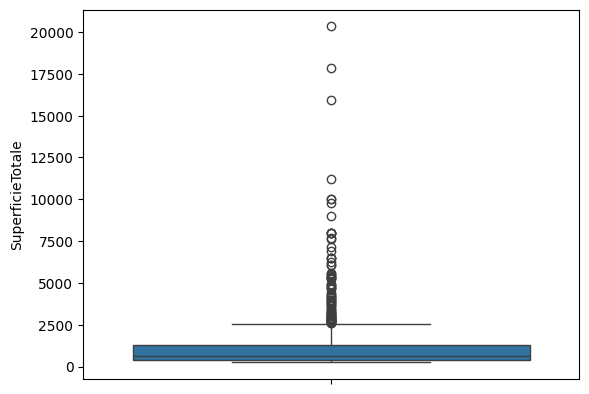

In [68]:
#Box Plot of 'SuperficieTotale' values to visually detect outliers
sns.boxplot(DATA["SuperficieTotale"])

In [69]:
#Z-Score on attribute 'SuperficieVendita'
#some outliers are found, but they are likely to be big shops
ZS(DATA["SuperficieVendita"], 4)

The detected outliers are:  [15930.0, 20340.0, 5500.0, 6000.0, 5660.0, 6350.0, 5960.0]


In [70]:
DATA[(DATA['Civico']==0)]

SettoreMerceologico            Insegna TipoVia                       Via  \
5       Non specificato       Non presente     Via                  ROGOREDO   
31    Non specializzato       Non presente     Via  BICOCCA DEGLI ARCIMBOLDI   
137   Non specializzato          esselunga     Via         PEZZOTTI GIOVANNI   
269   Non specializzato  suprmercato dufry  Piazza              DUCA D'AOSTA   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
5         0       4373   4            15930.0                 0.0   
31        0       1728   9             5500.0              4296.0   
137       0       5244   5             1490.0                 0.0   
269       0       1200   2             1038.0               694.0   

     SuperficieTotale      TipoAccesso  Isolato  
5             15930.0  Non specificato       63  
31             9796.0  accesso esterno       73  
137            1490.0  accesso esterno       17  
269            1732.0  accesso interno      159

In [71]:
#visualization of potential "outliers"
#'la rinascente' and 'ipercoop' are big shops, so the values are likely to be correct
#we don't know about the others, but we decide not to drop them
outliers= [15930.0, 20340.0, 5500.0, 6000.0, 5660.0, 6350.0, 5960.0]
DATA[DATA['SuperficieVendita'].isin(outliers)]

SettoreMerceologico                   Insegna TipoVia  \
5       Non specificato              Non presente     Via   
9       Non specificato             la rinascente     Via   
31    Non specializzato              Non presente     Via   
34    Non specializzato              Non presente     Via   
167   Non specializzato                  ipercoop     Via   
176   Non specializzato             la rinascente   Viale   
180   Non specializzato  licenza madre ce palizzi     Via   

                          Via  Civico  CodiceVia  ZD  SuperficieVendita  \
5                    ROGOREDO       0       4373   4            15930.0   
9             SANTA RADEGONDA       3        208   1            20340.0   
31   BICOCCA DEGLI ARCIMBOLDI       0       1728   9             5500.0   
34            GOZZOLI BENOZZO     130       6789   7             6000.0   
167           GOZZOLI BENOZZO     130       6789   7             5660.0   
176                   CERTOSA      29       7174   8             6350.0   
180           PALIZZI FILIPPO      69       7451   8             5960.0   

     SuperficieAltriUsi  SuperficieTotale      TipoAccesso  Isolato  
5                   0.0           15930.0  Non specificato       63  
9                   0.0           20340.0  accesso esterno      417  
31               4296.0            9796.0  accesso esterno       73  
34               2000.0            8000.0  Non specificato      207  
167              2340.0            8000.0  accesso esterno      207  
176              3670.0           10020.0  accesso esterno      330  
180              4040.0           10000.0  accesso esterno      107

<Axes: ylabel='SuperficieVendita'>

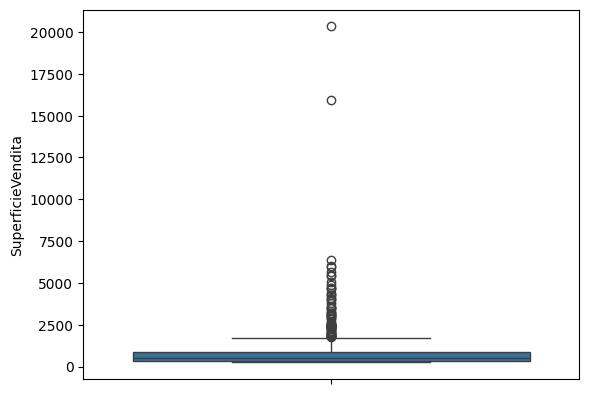

In [72]:
#Box Plot of 'SuperficieVendita' values to visually detect outliers
sns.boxplot(DATA["SuperficieVendita"])

In [73]:
#Z-Score on attribute 'SuperficieAltriUsi'
#some outliers are found, but they are likely to be big shops
ZS(DATA["SuperficieAltriUsi"], 4)

The detected outliers are:  [4296.0, 4600.0, 5697.0, 17183.0, 8850.0, 6707.0, 5690.0, 6476.0]


<Axes: ylabel='SuperficieAltriUsi'>

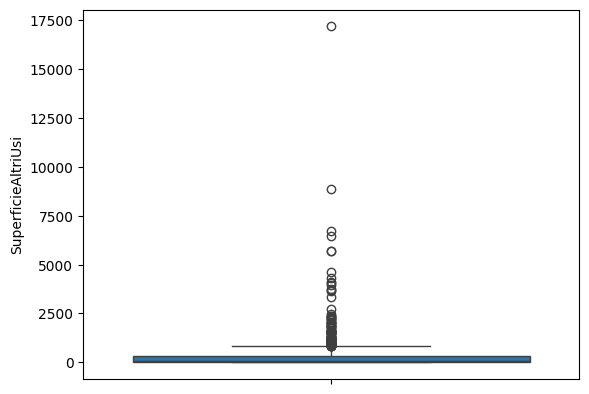

In [74]:
#Box Plot of 'SuperficieAltriUsi' values to visually detect outliers
sns.boxplot(DATA["SuperficieAltriUsi"])

In [75]:
from scipy.stats import skew
#evaluation of skewness
data_skewness = skew(DATA['SuperficieTotale'])
data_skewness

5.301429190742849

In [76]:
data_skewness = skew(DATA['SuperficieVendita'])
data_skewness

8.961866247282051

In [77]:
data_skewness = skew(DATA['SuperficieAltriUsi'])
data_skewness

9.050669654718984

In [78]:
#use of NearestNeighbors to identify outliers considering the three attributes simultanously
#considering also the 'CodiceVia', because if you have a lot of small shops in a Street, the presence
#of a big shop in the same street is unlikely
TEMP = pd.DataFrame(DATA, columns= ["SuperficieVendita", "SuperficieAltriUsi", "SuperficieTotale", "CodiceVia"])
X = TEMP.values
X

array([[ 292.,    0.,  292.,  626.],
       [ 800.,    0.,  800., 5150.],
       [ 726.,    0.,  726., 6589.],
       ...,
       [ 462.,  291.,  753., 1276.],
       [ 591.,  185.,  776., 6359.],
       [ 397.,  227.,  624., 1441.]])

In [79]:
#Instantiate model (KNN)
KNN = NearestNeighbors(n_neighbors = 3)
#Fit model
KNN.fit(X)
#Distances and indexes of k-neaighbors from model outputs
distances, indexes = KNN.kneighbors(X)
#Plot mean of k-distances of each observation
plt.plot(distances.mean(axis =1))

In [80]:
#Visually determine cutoff values > 1500
outliers_index = np.where(distances.mean(axis = 1) > 1500)
outliers_index

(array([  5,   9,  31, 572, 708, 802, 872, 889]),)

In [81]:
#Filter potential outlier values
DATA.iloc[outliers_index]

SettoreMerceologico                    Insegna TipoVia  \
5           Non specificato               Non presente     Via   
9           Non specificato              la rinascente     Via   
31        Non specializzato               Non presente     Via   
572  Settore non alimentare               Non presente   Viale   
708  Settore non alimentare  fiat succ. vendita assist     Via   
802  Settore non alimentare                media world   Viale   
872  Settore non alimentare             susa auto silo     Via   
889  Settore non alimentare                 varco spa.     Via   

                          Via  Civico  CodiceVia  ZD  SuperficieVendita  \
5                    ROGOREDO       0       4373   4            15930.0   
9             SANTA RADEGONDA       3        208   1            20340.0   
31   BICOCCA DEGLI ARCIMBOLDI       0       1728   9             5500.0   
572         LANCETTI VINCENZO      17       1221   9             1000.0   
708                    GROSIO       9       7483   8              675.0   
802               TROYA CARLO      18       5140   6             2350.0   
872             GOZZI GASPARE       5       3104   3              800.0   
889          DELL' INNOMINATO       2       5414   5              664.0   

     SuperficieAltriUsi  SuperficieTotale      TipoAccesso  Isolato  
5                   0.0           15930.0  Non specificato       63  
9                   0.0           20340.0  accesso esterno      417  
31               4296.0            9796.0  accesso esterno       73  
572              4600.0            5600.0  accesso esterno      103  
708             17183.0           17858.0  accesso esterno      202  
802              8850.0           11200.0  accesso interno      166  
872              5690.0            6490.0  accesso esterno      183  
889              6476.0            7140.0  accesso esterno       82

In [82]:
#Z-Score of 'Civico' to evaluate potential outliers
ZS(DATA["Civico"], 5)

The detected outliers are:  [260, 312, 289, 289, 260, 258, 264, 260]


In [83]:
#Analysis of potential outliers
#They are likely not to be outliers, since these streets are very long streets of Milan
#Even if these are big civic numbers, they are likely to be correct
outliers= [260, 312, 289, 289, 260, 258, 264, 260]
DATA[DATA['Civico'].isin(outliers)]

SettoreMerceologico             Insegna TipoVia                 Via  \
44        Non specializzato        Non presente   Viale        TESTI FULVIO   
261       Non specializzato  standa superfresco     Via  DELLE FORZE ARMATE   
581  Settore non alimentare        Non presente   Viale               MONZA   
582  Settore non alimentare        Non presente   Viale               MONZA   
592  Settore non alimentare        Non presente   Viale        TESTI FULVIO   
713  Settore non alimentare   f.lli simoni snc.   Viale               MONZA   
810  Settore non alimentare               midas     Via         LORENTEGGIO   
851  Settore non alimentare               sagam   Viale        TESTI FULVIO   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
44      260       1441   9             4280.0              1194.0   
261     312       6643   7             1250.0              1625.0   
581     289       2274   2              272.0               106.0   
582     289       2274   2              584.0                 0.0   
592     260       1441   9              530.0              2240.0   
713     258       2274   2              550.0                 0.0   
810     264       5132   6              607.0                 0.0   
851     260       1441   9              440.0               640.0   

     SuperficieTotale            TipoAccesso  Isolato  
44             5474.0        Non specificato       59  
261            2875.0        accesso esterno      158  
581             378.0        accesso esterno       64  
582             584.0  area aperta recintata       64  
592            2770.0        accesso esterno       45  
713             550.0        accesso esterno       40  
810             607.0        accesso esterno       86  
851            1080.0  area aperta recintata       45

<Axes: ylabel='Civico'>

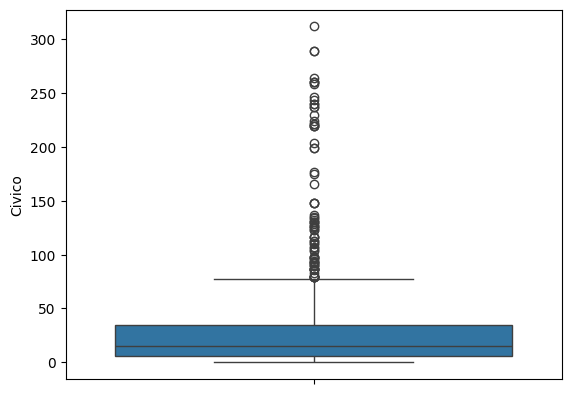

In [84]:
#Box Plot to visually detect outliers
sns.boxplot(DATA["Civico"])

**6) DATA CLEANING ( DATA DEDUPLICATION )**

In [85]:
#Presence of exact duplicated
DATA.duplicated().any()

True

In [86]:
#Number of exact duplicates
DATA.duplicated().sum()

1

In [87]:
#Dropping exact matching duplicates
DATA= DATA.drop_duplicates()
DATA

SettoreMerceologico              Insegna TipoVia                   Via  \
0         Non specificato         Non presente  Piazza              CORDUSIO   
1         Non specificato         Non presente    Ripa       DI PTA TICINESE   
2         Non specificato         Non presente     Via  ALBERICO DA ROSCIATE   
3         Non specificato         Non presente     Via   ASTESANI ALESSANDRO   
4         Non specificato         Non presente     Via       MONTE NAPOLEONE   
..                    ...                  ...     ...                   ...   
906  Settore di monopolio         Non presente     Via          MACCHI MAURO   
907    Settore carburanti         Non presente     Via             GALLARATE   
908  Settore farmaceutico             farmacia     Via      MAFFUCCI ANGIOLO   
909  Settore farmaceutico  farmacia cassiodoro   Viale            CASSIODORO   
910  Settore farmaceutico     farmacia scevola   Viale          TESTI FULVIO   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
0         2        626   1              292.0                 0.0   
1        73       5150   6              800.0                 0.0   
2         5       6589   7              726.0                 0.0   
3        17       1558   9              370.0                 0.0   
4         6        219   1              270.0                 0.0   
..      ...        ...  ..                ...                 ...   
906      42       2133   2              350.0               475.0   
907      40       7420   8              800.0               100.0   
908      40       1276   9              462.0               291.0   
909      12       6359   8              591.0               185.0   
910      90       1441   9              397.0               227.0   

     SuperficieTotale      TipoAccesso  Isolato  
0               292.0  accesso esterno      436  
1               800.0  Non specificato       86  
2               726.0  Non specificato      181  
3               370.0  accesso esterno      100  
4               270.0  Non specificato      280  
..                ...              ...      ...  
906             825.0  accesso interno       31  
907             900.0  accesso esterno      228  
908             753.0  accesso interno      259  
909             776.0  accesso esterno      151  
910             624.0  accesso esterno      145  

[910 rows x 12 columns]

In [88]:
#reindexing dataset in Pandas, because a tuple was dropped
DATA = DATA.reset_index(drop=True)

In [89]:
#Sorting the record in the database on the basis of a key (CodiceVia)
#the choice of 'CodiceVia' as a key is due to the fact that shops should be at
#least in the same Street to be considered duplicates. That's why records with the
#same 'CodiceVia' should be placed in the same window to be compared
indexer = recordlinkage.index.SortedNeighbourhood(on='CodiceVia', window=9)
candidate_links = indexer.index(DATA)
candidate_links

MultiIndex([( 12,   2),
            ( 20,   2),
            ( 21,   2),
            ( 32,  15),
            ( 44,  11),
            ( 61,  44),
            ( 62,  25),
            ( 67,  47),
            ( 68,  59),
            ( 79,  32),
            ...
            (903, 157),
            (905, 496),
            (905, 497),
            (906, 182),
            (907, 237),
            (907, 590),
            (907, 591),
            (908, 384),
            (909,  61),
            (909, 164)],
           length=9048)

In [90]:
DATA.columns

Index(['SettoreMerceologico', 'Insegna', 'TipoVia', 'Via', 'Civico',
       'CodiceVia', 'ZD', 'SuperficieVendita', 'SuperficieAltriUsi',
       'SuperficieTotale', 'TipoAccesso', 'Isolato'],
      dtype='object')

In [91]:
#First run of record linkage
#There are 12 conditions (one for each attribute)
compare_cl = recordlinkage.Compare()

#exact matching
compare_cl.exact('TipoVia', 'TipoVia', label='TipoVia')
compare_cl.exact('Civico', 'Civico', label='Civico')
compare_cl.exact('CodiceVia', 'CodiceVia', label='CodiceVia')
compare_cl.exact('ZD', 'ZD', label='ZD')
compare_cl.exact('SuperficieVendita', 'SuperficieVendita', label='SuperficieVendita')
compare_cl.exact('SuperficieAltriUsi', 'SuperficieAltriUsi', label='SuperficieAltriUsi')
compare_cl.exact('SuperficieTotale', 'SuperficieTotale', label='SuperficieTotale')
compare_cl.exact('Isolato', 'Isolato', label='Isolato')

#similarity measures (it's likely to have typos in this kind of attributes
#so we decided not to use exact matching)
compare_cl.string('Insegna', 'Insegna', method='jarowinkler', threshold=0.9, label='Insegna')
compare_cl.string('Via', 'Via', method='jarowinkler', threshold=0.9, label='Via')
compare_cl.string('TipoAccesso', 'TipoAccesso', method='jarowinkler', threshold=0.9, label='TipoAccesso')
compare_cl.string('SettoreMerceologico', 'SettoreMerceologico', method='jarowinkler', threshold=0.9, label='SettoreMerceologico')

features = compare_cl.compute(candidate_links, DATA)
matches = features[features.sum(axis=1) > 11]

matches

TipoVia  Civico  CodiceVia  ZD  SuperficieVendita  \
589 588        1       1          1   1                  1   

         SuperficieAltriUsi  SuperficieTotale  Isolato  Insegna  Via  \
589 588                   1                 1        1      1.0  1.0   

         TipoAccesso  SettoreMerceologico  
589 588          1.0                  1.0

In [92]:
matches.index

MultiIndex([(589, 588)],
           )

In [93]:
#analysis of potential duplicates
for i in matches.index:
    print(DATA2.iloc[[i[0],i[1]]])

        SettoreMerceologico       Insegna TipoVia       Via Civico CodiceVia  \
589  Settore non alimentare  Non presente   Viale  SABOTINO      4      4046   
588  Settore non alimentare  Non presente   Viale  SABOTINO      4      4046   

    ZD  SuperficieVendita  SuperficieAltriUsi  SuperficieTotale  \
589  5              350.0                 0.0             350.0   
588  5              350.0                 0.0             350.0   

         TipoAccesso  Isolato  Isolato_imp  
589  accesso interno    171.0        171.0  
588  accesso esterno    171.0        171.0  


In [94]:
#only the attribute 'TipoAccesso' is different, so the two records are likely to be
#duplicates. We drop the second row
DATA_DROP_DUPLICATES = DATA.copy()
indexes = []
for i in matches.index:
    if i[1] not in indexes:
        DATA_DROP_DUPLICATES = DATA_DROP_DUPLICATES.drop([i[1]])
    indexes.append(i[1])

In [95]:
DATA_DROP_DUPLICATES

SettoreMerceologico              Insegna TipoVia                   Via  \
0         Non specificato         Non presente  Piazza              CORDUSIO   
1         Non specificato         Non presente    Ripa       DI PTA TICINESE   
2         Non specificato         Non presente     Via  ALBERICO DA ROSCIATE   
3         Non specificato         Non presente     Via   ASTESANI ALESSANDRO   
4         Non specificato         Non presente     Via       MONTE NAPOLEONE   
..                    ...                  ...     ...                   ...   
905  Settore di monopolio         Non presente     Via          MACCHI MAURO   
906    Settore carburanti         Non presente     Via             GALLARATE   
907  Settore farmaceutico             farmacia     Via      MAFFUCCI ANGIOLO   
908  Settore farmaceutico  farmacia cassiodoro   Viale            CASSIODORO   
909  Settore farmaceutico     farmacia scevola   Viale          TESTI FULVIO   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
0         2        626   1              292.0                 0.0   
1        73       5150   6              800.0                 0.0   
2         5       6589   7              726.0                 0.0   
3        17       1558   9              370.0                 0.0   
4         6        219   1              270.0                 0.0   
..      ...        ...  ..                ...                 ...   
905      42       2133   2              350.0               475.0   
906      40       7420   8              800.0               100.0   
907      40       1276   9              462.0               291.0   
908      12       6359   8              591.0               185.0   
909      90       1441   9              397.0               227.0   

     SuperficieTotale      TipoAccesso  Isolato  
0               292.0  accesso esterno      436  
1               800.0  Non specificato       86  
2               726.0  Non specificato      181  
3               370.0  accesso esterno      100  
4               270.0  Non specificato      280  
..                ...              ...      ...  
905             825.0  accesso interno       31  
906             900.0  accesso esterno      228  
907             753.0  accesso interno      259  
908             776.0  accesso esterno      151  
909             624.0  accesso esterno      145  

[909 rows x 12 columns]

In [96]:
#Dropping the index because we dropped a tuple
DATA = DATA_DROP_DUPLICATES.reset_index(drop=True)

#Second run of the record linkage, using the same key as before, but relaxing the
#matching conditions
indexer = recordlinkage.index.SortedNeighbourhood(on='CodiceVia', window=9)

candidate_links = indexer.index(DATA)
candidate_links

MultiIndex([( 12,   2),
            ( 20,   2),
            ( 21,   2),
            ( 32,  15),
            ( 44,  11),
            ( 61,  44),
            ( 62,  25),
            ( 67,  47),
            ( 68,  59),
            ( 79,  32),
            ...
            (902, 157),
            (904, 496),
            (904, 497),
            (905, 182),
            (906, 237),
            (906, 589),
            (906, 590),
            (907, 384),
            (908,  61),
            (908, 164)],
           length=9028)

In [97]:
#We decided to relax the matching conditions, not considering the various attributes
#of the shop floor area.
# A shop owner may have increased or decreased the shop floor are over time due to renovations or expansions
#and the dataset may include two different entries referring to the same shop with the old and the new shop floor area.
compare_cl = recordlinkage.Compare()

compare_cl.exact('TipoVia', 'TipoVia', label='TipoVia')
compare_cl.exact('Civico', 'Civico', label='Civico')
compare_cl.exact('CodiceVia', 'CodiceVia', label='CodiceVia')
compare_cl.exact('ZD', 'ZD', label='ZD')
compare_cl.exact('Isolato', 'Isolato', label='Isolato')

compare_cl.string('Insegna', 'Insegna', method='jarowinkler', threshold=0.9, label='Insegna')
compare_cl.string('Via', 'Via', method='jarowinkler', threshold=0.9, label='Via')
compare_cl.string('TipoAccesso', 'TipoAccesso', method='jarowinkler', threshold=0.9, label='TipoAccesso')
compare_cl.string('SettoreMerceologico', 'SettoreMerceologico', method='jarowinkler', threshold=0.9, label='SettoreMerceologico')
features = compare_cl.compute(candidate_links, DATA)
matches = features[features.sum(axis=1) > 8]

matches

TipoVia  Civico  CodiceVia  ZD  Isolato  Insegna  Via  TipoAccesso  \
21  20         1       1          1   1        1      1.0  1.0          1.0   
170 169        1       1          1   1        1      1.0  1.0          1.0   
331 328        1       1          1   1        1      1.0  1.0          1.0   
364 363        1       1          1   1        1      1.0  1.0          1.0   
370 369        1       1          1   1        1      1.0  1.0          1.0   
537 536        1       1          1   1        1      1.0  1.0          1.0   
609 608        1       1          1   1        1      1.0  1.0          1.0   
873 872        1       1          1   1        1      1.0  1.0          1.0   

         SettoreMerceologico  
21  20                   1.0  
170 169                  1.0  
331 328                  1.0  
364 363                  1.0  
370 369                  1.0  
537 536                  1.0  
609 608                  1.0  
873 872                  1.0

In [98]:
matches.index

MultiIndex([( 21,  20),
            (170, 169),
            (331, 328),
            (364, 363),
            (370, 369),
            (537, 536),
            (609, 608),
            (873, 872)],
           )

In [99]:
#visualizing possible duplicates
for i in matches.index:
    print(DATA.iloc[[i[0],i[1]]])

   SettoreMerceologico       Insegna   TipoVia        Via  Civico  CodiceVia  \
21   Non specializzato  Non presente  Piazzale  SELINUNTE       2       6566   
20   Non specializzato  Non presente  Piazzale  SELINUNTE       2       6566   

    ZD  SuperficieVendita  SuperficieAltriUsi  SuperficieTotale  \
21   7              329.0               323.0             652.0   
20   7              329.0               424.0             753.0   

        TipoAccesso  Isolato  
21  accesso esterno      204  
20  accesso esterno      204  
    SettoreMerceologico   Insegna TipoVia                Via  Civico  \
170   Non specializzato  ipercoop     Via  QUARENGHI GIACOMO      23   
169   Non specializzato  ipercoop     Via  QUARENGHI GIACOMO      23   

     CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  SuperficieTotale  \
170       7478   8             3990.0                 0.0            3990.0   
169       7478   8              560.0                 0.0             560.0   

         

In [100]:
#Dropping duplicates (we keep the first tuple)
#All the records have the same values for all attributes except for the shop floor area ones.
#So they are likely to be duplicates (we drop the second row)
DATA_DROP_DUPLICATES = DATA.copy()
indexes = []
for i in matches.index:
    if i[1] not in indexes:
        DATA_DROP_DUPLICATES = DATA_DROP_DUPLICATES.drop([i[1]])
    indexes.append(i[1])

In [101]:
DATA_DROP_DUPLICATES = DATA_DROP_DUPLICATES.reset_index(drop=True)
DATA = DATA_DROP_DUPLICATES.copy()
DATA

SettoreMerceologico              Insegna TipoVia                   Via  \
0         Non specificato         Non presente  Piazza              CORDUSIO   
1         Non specificato         Non presente    Ripa       DI PTA TICINESE   
2         Non specificato         Non presente     Via  ALBERICO DA ROSCIATE   
3         Non specificato         Non presente     Via   ASTESANI ALESSANDRO   
4         Non specificato         Non presente     Via       MONTE NAPOLEONE   
..                    ...                  ...     ...                   ...   
896  Settore di monopolio         Non presente     Via          MACCHI MAURO   
897    Settore carburanti         Non presente     Via             GALLARATE   
898  Settore farmaceutico             farmacia     Via      MAFFUCCI ANGIOLO   
899  Settore farmaceutico  farmacia cassiodoro   Viale            CASSIODORO   
900  Settore farmaceutico     farmacia scevola   Viale          TESTI FULVIO   

     Civico  CodiceVia  ZD  SuperficieVendita  SuperficieAltriUsi  \
0         2        626   1              292.0                 0.0   
1        73       5150   6              800.0                 0.0   
2         5       6589   7              726.0                 0.0   
3        17       1558   9              370.0                 0.0   
4         6        219   1              270.0                 0.0   
..      ...        ...  ..                ...                 ...   
896      42       2133   2              350.0               475.0   
897      40       7420   8              800.0               100.0   
898      40       1276   9              462.0               291.0   
899      12       6359   8              591.0               185.0   
900      90       1441   9              397.0               227.0   

     SuperficieTotale      TipoAccesso  Isolato  
0               292.0  accesso esterno      436  
1               800.0  Non specificato       86  
2               726.0  Non specificato      181  
3               370.0  accesso esterno      100  
4               270.0  Non specificato      280  
..                ...              ...      ...  
896             825.0  accesso interno       31  
897             900.0  accesso esterno      228  
898             753.0  accesso interno      259  
899             776.0  accesso esterno      151  
900             624.0  accesso esterno      145  

[901 rows x 12 columns]

In [102]:
#data quality assessment for each column
for col in DATA.columns:
    print("DQ Assessment for "+col+":")

    DISTINCT = (DATA[col].nunique())
    COUNT = DATA[col].count()

    ROWS = len(DATA[col])
    UNIQUENESS = DISTINCT / ROWS
    print("UNIQUENESS: ", UNIQUENESS)

    DISTINCTNESS = DISTINCT / COUNT
    print("DISTINCTNESS: ", DISTINCTNESS)

    MAX_COUNTS = max(DATA[col].value_counts())
    CONSTANCY = MAX_COUNTS / COUNT
    print("CONSTANCY: ", CONSTANCY)

#completeness evaluation at attribute level (completeness of the single column)
    NOT_NULL = DATA[col].count().sum()
    NULL = DATA[col].isnull().sum().sum()
    TOT = DATA[col].shape[0]
    COMPLETENESS = NOT_NULL / TOT
    print("COMPLETENESS: ", COMPLETENESS)

#accuracy for attribute 'ZD' using ZONES_OF_MILAN to evaluate it
    if col == 'ZD' :
      CORRECT = DATA['ZD'].isin(ZONES_OF_MILAN['ZD'])
      CORRECT_ZD = np.sum(CORRECT)
      NOT_NULL_ZD = DATA['ZD'].count()
      ACCURACY = CORRECT_ZD/NOT_NULL_ZD
      print("ZD ACCURACY: ", ACCURACY)

    print("\n\n")

DQ Assessment for SettoreMerceologico:
UNIQUENESS:  0.00776914539400666
DISTINCTNESS:  0.00776914539400666
CONSTANCY:  0.6625971143174251
COMPLETENESS:  1.0



DQ Assessment for Insegna:
UNIQUENESS:  0.3873473917869034
DISTINCTNESS:  0.3873473917869034
CONSTANCY:  0.38179800221975585
COMPLETENESS:  1.0



DQ Assessment for TipoVia:
UNIQUENESS:  0.014428412874583796
DISTINCTNESS:  0.014428412874583796
CONSTANCY:  0.6526082130965594
COMPLETENESS:  1.0



DQ Assessment for Via:
UNIQUENESS:  0.5493895671476138
DISTINCTNESS:  0.5493895671476138
CONSTANCY:  0.02774694783573807
COMPLETENESS:  1.0



DQ Assessment for Civico:
UNIQUENESS:  0.1365149833518313
DISTINCTNESS:  0.1365149833518313
CONSTANCY:  0.07991120976692564
COMPLETENESS:  1.0



DQ Assessment for CodiceVia:
UNIQUENESS:  0.5560488346281909
DISTINCTNESS:  0.5560488346281909
CONSTANCY:  0.025527192008879023
COMPLETENESS:  1.0



DQ Assessment for ZD:
UNIQUENESS:  0.009988901220865706
DISTINCTNESS:  0.009988901220865706
CONSTANCY:  

In [103]:
#completeness evaluation at table level (completeness of the whole dataset)
NOT_NULL = DATA.count().sum()
NULL = DATA.isnull().sum().sum()
TOT = DATA.shape[0]*DATA.shape[1]
COMPLETENESS = NOT_NULL / TOT
print("COMPLETENESS: ", COMPLETENESS)

COMPLETENESS:  1.0


In [104]:
#consistency evaluated with respect to a rule according to which the sum of 'Superficie vendita' and
# 'Superficie altri usi' should be equal to 'Superficie totale'
DATA['consistency'] = np.where(DATA['SuperficieTotale'] == (DATA['SuperficieVendita'] + DATA['SuperficieAltriUsi']) , 1, 0)
CONSISTENT = DATA['consistency'].sum()
COUNT = DATA['consistency'].count()
CONSISTENCY = CONSISTENT/COUNT
DATA = DATA.drop(columns= ["consistency"])
print("CONSISTENCY: ", CONSISTENCY)

CONSISTENCY:  1.0


In [105]:
#Exporting cleaned dataset
DATA.to_csv('/content/drive/MyDrive/DIQProject/cleanedDB_group6.csv', index=False)